In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

# Dual LSTM Complete data

In [ ]:
tagged_sentence = []
l = os.listdir('/content/temp/')
path = '/content/temp/'
for i in l:
  print(path+str(i))
  f = open(path+str(i),'r')

  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)
  f.close()
print(len(tagged_sentence))

/content/temp/guj_sports_sample7.txt
/content/temp/guj_entertainment_sample3.txt
/content/temp/guj_philosophy_sample4.txt
/content/temp/guj_economy_sample2.txt
/content/temp/guj_art and culture_sample1.txt
/content/temp/guj_science and technology_sample6.txt
/content/temp/guj_religion_sample5.txt
7000


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 20609
Unique tags: 34
Unique characters: 140


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
print("Training set Size ",len(train))
print("Test set Size ",len(test))
print("Sample Test")
print(test[2])

Training set Size  6650
Test set Size  350
Sample Test
[('લંચ', 'N_NN'), ('બાદના', 'PSP'), ('૩૩', 'QT_QTC'), ('ઓવરના', 'N_NN'), ('સેશનમાં', 'N_NN'), ('ભારતે', 'N_NNP'), ('૧૦૬', 'QT_QTC'), ('રન', 'N_NN'), ('નોંધાવતા', 'V_VAUX_VNP'), ('ઑસ્ટ્રેલિયાને', 'N_NNP'), ('પરેશાન', 'JJ'), ('કરી', 'V_VM'), ('દીધું', 'V_VAUX'), ('હતું', 'V_VAUX'), ('.', 'RD_PUNC')]


## Adam LSTM

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 3 Completed,	Loss 1.442962214544726e-05	Accuracy: 0.9277070363362631
Epoch 6 Completed,	Loss 3.417571991803925e-05	Accuracy: 0.9863336682319641
Epoch 9 Completed,	Loss 9.60057254436227e-08	Accuracy: 0.9917619625727335
Epoch 12 Completed,	Loss 1.004008473396804e-07	Accuracy: 0.9935305317242941
Epoch 15 Completed,	Loss 8.12442096146763e-06	Accuracy: 0.9941595196723938
Epoch 18 Completed,	Loss 2.770627594017583e-07	Accuracy: 0.9944162567456564
Epoch 21 Completed,	Loss 7.389150447068005e-08	Accuracy: 0.99459308385849
Epoch 24 Completed,	Loss 1.475744270488614e-07	Accuracy: 0.9946961402893066
Epoch 27 Completed,	Loss 9.336184566185087e-09	Accuracy: 0.9949831167856852


In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

In [ ]:
final_true['lstm'] = y_true
final_pred['lstm'] = y_pred

In [ ]:
tags = ['N_NN', 'PR_PRL', 'JJ', 'V_VAUX_VNP', 'V_VAUX', 'N_NNP', 'RD_PUNC', 'DM_DMD', 'N_NST', 'PR_PRI', 'PR_PRP', 'V_VM', 'PSP', 'DM_DMI', 'RP_RPD', 'QT_QTF', 'RP_NEG', 'CC_CCD', 'QT_QTC', 'RD_SYM', 'CC_CCS', 'PR_PRF', 'PR_PRQ', 'DM_DMQ', 'CC_CCS_UT', 'PR_PRC', 'QT_QTO', 'RB', 'RD_RDF', 'DM_DMR','RP_INJ','RD_ECH','RP_INTF','RP_CL']
heading = ['guj_entertainment_sample3','guj_philosophy_sample4','guj_science and technology_sample6','guj_sports_sample7','guj_religion_sample5','guj_economy_sample2','guj_art and culture_sample1']
total_true = {}
total_false = {}

for i in tags:
  total_true[i] = 0;
  total_false[i]=0;

def evaluations(true,pred):
  dictt = {}
  for i in tags:
    dictt[i]={}
  
  for i in range(len(true)):
    if(true[i]==pred[i]):
      total_true[true[i]] += 1
      continue
    
    total_false[true[i]] += 1
    if(pred[i] in dictt[true[i]].keys()):
      dictt[true[i]][pred[i]] += 1
    else:
      dictt[true[i]][pred[i]] = 1
  return dictt

res = evaluations(y_true,y_pred)
print(res)

In [ ]:
for i in list(total_true):
  if(total_true[i]==0):
    total_true.pop(i)

for i in list(total_false):
  if(total_false[i]==0):
    total_false.pop(i)

## RMSPROP

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 10

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 1 Completed,	Loss 1.7202439266839065e-05	Accuracy: 0.8609294891357422
Epoch 2 Completed,	Loss 7.358879656749195e-07	Accuracy: 0.9461126327514648
Epoch 3 Completed,	Loss 6.569595825567376e-06	Accuracy: 0.9747597575187683
Epoch 4 Completed,	Loss 8.208967869904882e-07	Accuracy: 0.985115647315979
Epoch 5 Completed,	Loss 1.7697522025628132e-07	Accuracy: 0.9892654418945312
Epoch 6 Completed,	Loss 3.250686120281898e-08	Accuracy: 0.9914404153823853
Epoch 7 Completed,	Loss 5.675374632119201e-05	Accuracy: 0.9926438331604004
Epoch 8 Completed,	Loss 6.401297287084162e-05	Accuracy: 0.9936828017234802
Epoch 9 Completed,	Loss 1.5071034198399502e-08	Accuracy: 0.9937152862548828
Epoch 10 Completed,	Loss 8.873750800830749e-08	Accuracy: 0.9941039085388184


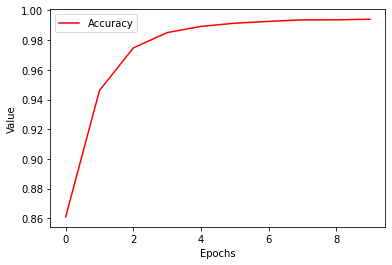

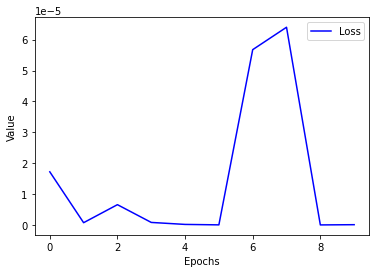

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7734751203852327

In [ ]:
tags = ['N_NN', 'PR_PRL', 'JJ', 'V_VAUX_VNP', 'V_VAUX', 'N_NNP', 'RD_PUNC', 'DM_DMD', 'N_NST', 'PR_PRI', 'PR_PRP', 'V_VM', 'PSP', 'DM_DMI', 'RP_RPD', 'QT_QTF', 'RP_NEG', 'CC_CCD', 'QT_QTC', 'RD_SYM', 'CC_CCS', 'PR_PRF', 'PR_PRQ', 'DM_DMQ', 'CC_CCS_UT', 'PR_PRC', 'QT_QTO', 'RB', 'RD_RDF', 'DM_DMR','RP_INJ','RD_ECH','RP_INTF','RP_CL']
heading = ['guj_entertainment_sample3','guj_philosophy_sample4','guj_science and technology_sample6','guj_sports_sample7','guj_religion_sample5','guj_economy_sample2','guj_art and culture_sample1']
total_true = {}
total_false = {}

for i in tags:
  total_true[i] = 0;
  total_false[i]=0;

def evaluations(true,pred):
  dictt = {}
  for i in tags:
    dictt[i]={}
  
  for i in range(len(true)):
    if(true[i]==pred[i]):
      total_true[true[i]] += 1
      continue
    
    total_false[true[i]] += 1
    if(pred[i] in dictt[true[i]].keys()):
      dictt[true[i]][pred[i]] += 1
    else:
      dictt[true[i]][pred[i]] = 1
  return dictt

res = evaluations(y_true,y_pred)
print(res)

{'N_NN': {'QT_QTC': 19, 'DM_DMD': 6, 'V_VAUX_VNP': 13, 'N_NNP': 25, 'RD_PUNC': 3, 'QT_QTF': 5, 'JJ': 71, 'RP_RPD': 6, 'V_VAUX': 5, 'CC_CCD': 7, 'PSP': 26, 'V_VM': 31, 'N_NST': 6, 'PR_PRP': 4, 'RP_NEG': 4, 'PR_PRL': 1, 'PR_PRF': 1}, 'PR_PRL': {'JJ': 1, 'N_NN': 5, 'N_NST': 1}, 'JJ': {'N_NN': 85, 'V_VM': 9, 'PSP': 10, 'N_NNP': 8, 'QT_QTC': 5, 'CC_CCD': 2, 'QT_QTF': 1, 'RP_RPD': 3, 'V_VAUX_VNP': 3, 'PR_PRP': 2, 'N_NST': 1, 'RB': 1, 'PR_PRF': 1, 'PR_PRL': 1, 'QT_QTO': 1, 'DM_DMD': 1, 'RP_NEG': 1}, 'V_VAUX_VNP': {'V_VM': 29, 'V_VAUX': 2, 'N_NN': 109, 'PR_PRF': 1, 'RP_RPD': 3, 'JJ': 44, 'RP_NEG': 3, 'QT_QTC': 10, 'PSP': 27, 'DM_DMD': 4, 'N_NNP': 16, 'N_NST': 2, 'RD_PUNC': 2, 'QT_QTF': 1, 'QT_QTO': 1}, 'V_VAUX': {'N_NN': 17, 'V_VM': 18, 'JJ': 4, 'N_NNP': 1}, 'N_NNP': {'N_NN': 63, 'RP_RPD': 2, 'PR_PRP': 4, 'PSP': 15, 'RD_SYM': 1, 'V_VM': 14, 'RD_PUNC': 6, 'JJ': 17, 'V_VAUX': 2, 'N_NST': 1, 'PR_PRI': 1, 'QT_QTO': 2, 'DM_DMD': 1, 'QT_QTC': 4, 'V_VAUX_VNP': 1, 'PR_PRF': 1, 'RD_RDF': 1, 'QT_QTF': 1

In [ ]:
for i in list(total_true):
  if(total_true[i]==0):
    total_true.pop(i)

for i in list(total_false):
  if(total_false[i]==0):
    total_false.pop(i)

## sgd

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 10

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch 1 Completed,	Loss 0.0006534114945679903	Accuracy: 0.4276215732097626
Epoch 2 Completed,	Loss 0.0005495919031091034	Accuracy: 0.5104318857192993
Epoch 3 Completed,	Loss 0.0004770022351294756	Accuracy: 0.5633875727653503
Epoch 4 Completed,	Loss 0.00039462928543798625	Accuracy: 0.5903913378715515
Epoch 5 Completed,	Loss 0.00031836560810916126	Accuracy: 0.6207294464111328
Epoch 6 Completed,	Loss 0.0002571594377513975	Accuracy: 0.6502953767776489
Epoch 7 Completed,	Loss 0.0002118787233484909	Accuracy: 0.6785439252853394
Epoch 8 Completed,	Loss 0.00017949238826986402	Accuracy: 0.7022699117660522
Epoch 9 Completed,	Loss 0.00015646811516489834	Accuracy: 0.7198212742805481
Epoch 10 Completed,	Loss 0.00013995059998705983	Accuracy: 0.7362135052680969


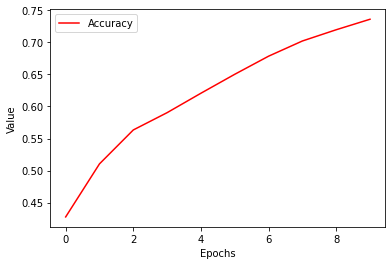

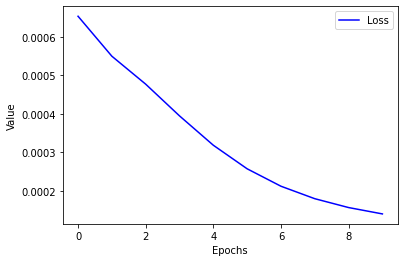

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('ભારતીય', 'JJ'), ('તત્ત્વવિચારની', 'JJ'), ('મુખ્ય', 'JJ'), ('અને', 'CC_CCD'), ('મહત્ત્વની', 'JJ'), ('શાખાઓ', 'N_NN'), ('વેદ', 'N_NN'), ('-', 'RD_PUNC'), ('આધારિત', 'RD_PUNC'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('વર્ગીકરણ', 'N_NN'), ('ભારતીય', 'JJ'), ('તત્ત્વવિચારના', 'JJ'), ('કેન્દ્રમાં', 'N_NN'), ('વેદ', 'N_NN'), ('છે', 'V_VAUX'), ('તેનું', 'DM_DMD'), ('જ', 'RP_RPD'), ('સમર્થન', 'N_NN'), ('કરે', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('સંહિતામાં', 'N_NN'), ('બ્રાહ્મણ', 'V_VM'), (',', 'RD_PUNC'), ('આરણ્યક', 'N_NN'), ('અને', 'CC_CCD'), ('ઉપનિષદ', 'CC_CCD'), ('ઉમેરી', 'N_NN'), (',', 'RD_PUNC'), ('સર્વને', 'N_NN'), ('એકત્ર', 'N_NN'), ('કરી', 'V_VM'), (',', 'RD_PUNC'), ('એમને', 'RD_PUNC'), ('`', 'RD_PUNC'), ('વેદ', 'N_NNP'), ('`', 'RD_PUNC'), ('અથવા', 'CC_CCD'), ('`', 'RD_PUNC'), ('શ્રુતિને', 'N_NN'), ('`', 'RD_PUNC'), ('નામે', 'N_NN'), ('પ્રમાણ', 'N_NN'), ('માનવામાં', 'V_VM'), ('આવે', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('શુલ્વસૂત્ર', 'N_NN'), (':'

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.6857945425361156

In [ ]:
tags = ['N_NN', 'PR_PRL', 'JJ', 'V_VAUX_VNP', 'V_VAUX', 'N_NNP', 'RD_PUNC', 'DM_DMD', 'N_NST', 'PR_PRI', 'PR_PRP', 'V_VM', 'PSP', 'DM_DMI', 'RP_RPD', 'QT_QTF', 'RP_NEG', 'CC_CCD', 'QT_QTC', 'RD_SYM', 'CC_CCS', 'PR_PRF', 'PR_PRQ', 'DM_DMQ', 'CC_CCS_UT', 'PR_PRC', 'QT_QTO', 'RB', 'RD_RDF', 'DM_DMR','RP_INJ','RD_ECH','RP_INTF','RP_CL']
heading = ['guj_entertainment_sample3','guj_philosophy_sample4','guj_science and technology_sample6','guj_sports_sample7','guj_religion_sample5','guj_economy_sample2','guj_art and culture_sample1']
total_true = {}
total_false = {}

for i in tags:
  total_true[i] = 0;
  total_false[i]=0;

def evaluations(true,pred):
  dictt = {}
  for i in tags:
    dictt[i]={}
  
  for i in range(len(true)):
    if(true[i]==pred[i]):
      total_true[true[i]] += 1
      continue
    
    total_false[true[i]] += 1
    if(pred[i] in dictt[true[i]].keys()):
      dictt[true[i]][pred[i]] += 1
    else:
      dictt[true[i]][pred[i]] = 1
  return dictt

res = evaluations(y_true,y_pred)
print(res)

{'N_NN': {'JJ': 173, 'N_NNP': 4, 'DM_DMD': 10, 'PR_PRP': 11, 'PSP': 33, 'V_VAUX': 10, 'RD_PUNC': 9, 'V_VM': 67, 'RP_RPD': 2, 'QT_QTC': 6, 'N_NST': 3, 'V_VAUX_VNP': 4, 'CC_CCD': 6, 'QT_QTF': 3, 'DM_DMI': 1, 'CC_CCS': 3}, 'PR_PRL': {'JJ': 5, 'DM_DMD': 1, 'CC_CCS': 1, 'N_NN': 2, 'V_VM': 1, 'RD_PUNC': 5}, 'JJ': {'RD_PUNC': 2, 'N_NN': 166, 'CC_CCS': 1, 'QT_QTC': 1, 'RP_RPD': 2, 'PR_PRP': 5, 'PSP': 10, 'V_VM': 33, 'V_VAUX_VNP': 1, 'V_VAUX': 7, 'RD_SYM': 2, 'CC_CCD': 1, 'QT_QTF': 1, 'DM_DMD': 1}, 'V_VAUX_VNP': {'V_VM': 37, 'JJ': 40, 'N_NN': 129, 'RP_NEG': 3, 'RD_PUNC': 2, 'V_VAUX': 9, 'PSP': 13, 'CC_CCS': 1, 'RP_RPD': 2, 'QT_QTC': 1, 'DM_DMD': 4}, 'V_VAUX': {'N_NN': 10, 'JJ': 2, 'V_VM': 12}, 'N_NNP': {'N_NN': 123, 'V_VM': 19, 'CC_CCD': 4, 'DM_DMD': 4, 'JJ': 35, 'RD_PUNC': 8, 'PSP': 13, 'PR_PRP': 3, 'V_VAUX': 1, 'V_VAUX_VNP': 2, 'QT_QTC': 1}, 'RD_PUNC': {'N_NN': 1, 'RP_RPD': 1, 'V_VAUX_VNP': 1, 'PSP': 1, 'RP_NEG': 1}, 'DM_DMD': {'RD_PUNC': 2, 'PR_PRP': 3, 'PSP': 2, 'RP_RPD': 1, 'N_NN': 1}, 'N_

In [ ]:
for i in list(total_true):
  if(total_true[i]==0):
    total_true.pop(i)

for i in list(total_false):
  if(total_false[i]==0):
    total_false.pop(i)

# Each corpus RMSProp LSTM

## Helper

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [ ]:
print(dict_true.keys())

dict_keys(['sports', 'art', 'econo', 'philo', 'relegion', 'entern', 'sci'])


In [ ]:
k = dict_true.keys()
recall = []
Acc_plot = []
Loss_plot = []
precision_plot = []
f1score_plot = []
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

for i in k:
  y_true = dict_true[i]
  y_pred = dict_pred[i]
  print(y_true)
  print(y_pred)
  Acc_plot.append(accuracy_score(y_true, y_pred))
  recall.append(recall_score(y_true,y_pred,average='macro'))
  precision_plot.append(precision_score(y_true,y_pred,average='macro'))
  f1score_plot.append(f1_score(y_true, y_pred,average='macro'))

['DM_DMD', 'JJ', 'JJ', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NNP', 'RP_RPD', 'N_NN', 'PSP', 'PSP', 'N_NN', 'N_NNP', 'V_VM', 'DM_DMD', 'N_NN', 'RP_NEG', 'V_VAUX', 'RD_PUNC', 'CC_CCS', 'PR_PRP', 'JJ', 'N_NN', 'N_NN', 'PSP', 'JJ', 'V_VM', 'V_VAUX', 'RP_NEG', 'RD_PUNC', 'N_NNP', 'N_NNP', 'JJ', 'N_NN', 'N_NN', 'N_NNP', 'JJ', 'V_VAUX_VNP', 'N_NNP', 'N_NN', 'N_NN', 'V_VM', 'V_VAUX', 'V_VAUX', 'RD_PUNC', 'N_NNP', 'N_NNP', 'QT_QTC', 'PSP', 'N_NN', 'CC_CCD', 'QT_QTC', 'JJ', 'N_NN', 'N_NN', 'QT_QTO', 'N_NN', 'RP_RPD', 'PSP', 'V_VM', 'RD_PUNC', 'JJ', 'N_NN', 'N_NN', 'QT_QTC', 'N_NN', 'DM_DMD', 'N_NN', 'N_NN', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NN', 'QT_QTF', 'N_NN', 'N_NN', 'V_VM', 'V_VAUX', 'JJ', 'N_NN', 'N_NNP', 'N_NN', 'N_NN', 'QT_QTC', 'N_NN', 'CC_CCD', 'N_NNP', 'N_NN', 'N_NN', 'QT_QTC', 'N_NN', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NST', 'N_NNP', 'N_NNP', 'RP_RPD', 'QT_QTC', 'N_NN', 'JJ', 'N_NN', 'PSP', 'JJ', 'V_VAUX_VNP', 'N_NN', 'V_VM', 'V_VAUX', 'CC_CCD', 'PSP', 'PR_PRP', 'N_NN', 'V_VAUX_VNP', 'N_NN', 'Q

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(Acc_plot)
print(precision_plot)
print(f1score_plot)
print(recall)
# RMS PROP

[0.811554332874828, 0.7776280323450134, 0.8438485804416404, 0.7792592592592592, 0.730185497470489, 0.7311827956989247, 0.7667071688942891]
[0.8408531007406814, 0.6307043232131732, 0.8114314530761205, 0.6969047194659096, 0.6620093592501103, 0.6760229486702982, 0.7265412100068894]
[0.8159901481728, 0.6396266810060536, 0.813782692404294, 0.69022999270783, 0.6421046795356559, 0.6515741929247433, 0.7115456584355]
[0.8043623962124322, 0.6530257652273177, 0.8286965805812813, 0.7042679309025315, 0.6361203624862596, 0.6704566494907815, 0.7183238895833169]


## sports

In [ ]:
path = '/content/guj_sports_sample7.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 4269
Unique tags: 29
Unique characters: 107


In [ ]:
word_to_idx.keys()

dict_keys(['ભારતના', 'ટેસ્ટ', 'ઇતિહાસની', 'ઑસ્ટ્રેલિયા', 'સામે', 'વિકેટની', 'રીતે', 'સૌથી', 'મોટી', 'જીત', '.', 'ભારતનો', 'આઠ', 'વિકેટથી', 'ઐતિહાસિક', 'વિજય', 'ચેન્નાઈ', 'તારીખ', '૨૬', 'કેપ્ટન', 'ધોનીની', '૨૨૪', 'રનની', 'મેરેથોન', 'ઈનિંગની', 'મદદથી', 'ભારતે', 'સામેની', 'ચેન્નાઈમાં', 'રમાયેલી', 'પ્રથમ', 'ટેસ્ટમાં', 'મેળવી', 'લીધો', 'હતો', 'આજે', 'પાંચમા', 'અને', 'આખરી', 'દિવસે', 'ઑસ્ટ્રેલિયાની', 'બીજી', 'ઈનિંગ', '૨૪૧', 'રનમાં', 'સમેટાઈ', 'હતી', 'જે', 'પછી', 'જીતવા', 'માટેના', '૫૦', 'રનના', 'પડકારને', 'લંચની', '૪૦', 'મિનિટ', 'અગાઉ', 'જ', '૧૧.૩', 'ઓવરમાં', 'બે', 'વિકેટ', 'ગુમાવીને', 'જીતી', 'ધોનીને', 'મેન', 'ઓફ', 'ધ', 'મેચ', 'જાહેર', 'કરવામાં', 'આવ્યો', 'આ', 'સાથે', 'મેચોના', 'ઇતિહાસનો', 'મોટા', 'અંતરનો', 'મેળવ્યો', 'ચાર', 'ટેસ્ટની', 'શ્રેણીમાં', '૧-૦થી', 'સરસાઈ', 'પ્રાપ્ત', 'કરી', 'હવે', 'માર્ચથી', 'હૈદરાબાદમાં', 'ટેસ્ટનો', 'પ્રારંભ', 'થશે', 'ધોનીએ', 'ભારતીય', 'ઇતિહાસના', 'સફળ', 'તરીકે', 'ગાંગુલીના', 'રેકોર્ડની', 'બરોબરી', 'લીધી', 'ગાંગુલીએ', '૪૯', 'કેપ્ટન્સી', 'કરતાં', '૨૧', 'અપાવ્યા', 

In [ ]:
char_to_idx.keys()

dict_keys(['ભ', 'ા', 'ર', 'ત', 'ન', 'ટ', 'ે', 'સ', '્', 'ઇ', 'િ', 'હ', 'ી', 'ઑ', 'લ', 'ય', 'મ', 'વ', 'ક', 'ૌ', 'થ', 'ો', 'જ', '.', 'આ', 'ઠ', 'ઐ', 'ચ', 'ઈ', 'ખ', '૨', '૬', 'પ', 'ધ', '૪', 'ં', 'ગ', 'દ', 'ળ', 'અ', 'બ', '૧', 'છ', '૫', '૦', 'ડ', 'ઉ', '૩', 'ઓ', 'ુ', 'ફ', 'શ', 'ણ', '-', 'ૈ', 'એ', '૯', 'ૂ', '૮', '૭', 'ઘ', 'ષ', 'ઝ', 'ઊ', '`', 'ઞ', '(', ',', 'ઢ', 'ૃ', 'ઃ', '/', ':', 'ૉ', 'ૅ', 'F', 'I', 'A', ')', 'ઍ', 'C', 'R', 'E', 'K', 'T', '!', 'W', 'S', 'o', 'r', 'e', 'c', 't', 'a', 'n', 'd', 'i', 'g', 'p', 's', 'D', 'f', 'v', 'H', 'ઋ', '?', 'x'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 7.584654364715486e-05	Accuracy: 0.900730311870575
Epoch 6 Completed,	Loss 1.281621659169711e-06	Accuracy: 0.9941487312316895
Epoch 9 Completed,	Loss 2.188832676589906e-07	Accuracy: 0.9970173438390096
Epoch 12 Completed,	Loss 1.1532205597871345e-08	Accuracy: 0.9977051218350729
Epoch 15 Completed,	Loss 1.971875560983586e-09	Accuracy: 0.9977025985717773
Epoch 18 Completed,	Loss 2.5096683065051195e-10	Accuracy: 0.997740626335144
Epoch 21 Completed,	Loss 1.434096337053307e-10	Accuracy: 0.997821311155955
Epoch 24 Completed,	Loss 1.195080492899514e-11	Accuracy: 0.9979968070983887
Epoch 27 Completed,	Loss 5.97540246449757e-12	Accuracy: 0.9979196588198344
Epoch 30 Completed,	Loss 0.0	Accuracy: 0.9978210926055908


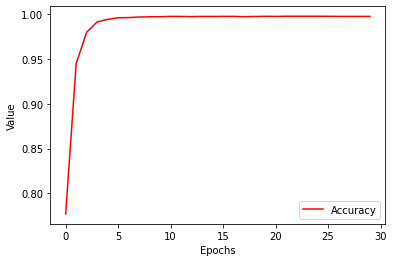

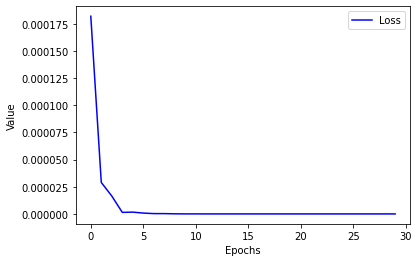

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('તે', 'DM_DMD'),
 ('વેધક', 'JJ'),
 ('પૂરવાર', 'JJ'),
 ('થાય', 'V_VM'),
 ('છે', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('તે', 'DM_DMD'), ('વેધક', 'JJ'), ('પૂરવાર', 'JJ'), ('થાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('અશ્વિનને', 'N_NNP'), ('પણ', 'RP_RPD'), ('મેન', 'N_NN'), ('ઓફ', 'PSP'), ('ધ', 'PSP'), ('મેચ', 'N_NN'), ('ધોની', 'N_NNP'), ('બન્યો', 'V_VM'), ('તેનો', 'PR_PRP'), ('વાંધો', 'N_NN'), ('નહીં', 'RP_NEG'), ('હોય', 'V_VAUX'), ('.', 'RD_PUNC')]
[('જોકે', 'CC_CCS'), ('તેઓ', 'PR_PRP'), ('આખરી', 'JJ'), ('દિવસે', 'N_NN'), ('પીચ', 'N_NN'), ('પર', 'PSP'), ('લાંબુ', 'JJ'), ('ટકી', 'N_NN'), ('શક્યા', 'N_NN'), ('નહતા', 'QT_QTC'), ('.', 'RD_PUNC')]
[('જાડેજાએ', 'N_NNP'), ('ઑસ્ટ્રેલિયાની', 'N_NNP'), ('આખરી', 'JJ'), ('વિકેટના', 'N_NN'), ('રૂપમાં', 'N_NN'), ('લિયોનને', 'V_VAUX_VNP'), ('આઉટ', 'JJ'), ('કરીને', 'V_VAUX_VNP'), ('ભારતની', 'N_NNP'), ('જીતને', 'N_NN'), ('આસાન', 'JJ'), ('કરી', 'V_VM'), ('દીધી', 'V_VAUX'), ('હતી', 'V_VAUX'), ('.', 'RD_PUNC')]
[('પ્રજ્ઞાન', 'N_NN'), ('ઓઝા', 'N_NN'), ('બે', 'QT_QTC'), ('ઓફ', 'PSP'), ('સ્પિનર', 'N_NN'), ('અને', 'CC_CCD'), ('એક', 'QT_QTC'), ('ડાબોડી', 'N_NN'), ('

In [ ]:
dict_true['sports'] = y_true
dict_pred['sports'] = y_pred

## guj_art and culture_sample1.txt

In [ ]:
path = '/content/guj_art and culture_sample1.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 5353
Unique tags: 30
Unique characters: 114


In [ ]:
word_to_idx.keys()

dict_keys(['સંગીતના', 'ઇતિહાસમાં', 'જેમનું', 'નામ', 'સુવર્ણ', 'અક્ષરે', 'અંકિત', 'થયેલું', 'છે', 'તે', 'જામનગરના', 'રાજગાયક', 'માસ્ટર', 'વસંત', '.', 'વર્ષો', 'પહેલાંની', 'આ', 'વાત', 'એ', 'કાળે', 'કવિવર', 'રવીન્દ્રનાથ', 'ટાગોર', 'યુરોપના', 'પ્રવાસે', 'ગયેલા', 'કોઈએ', 'એમને', 'પૂછ્યું', ':', '`', 'હિન્દુસ્તાનમાં', 'તમારા', 'સિવાય', 'બીજો', 'કોઈ', 'મોટો', 'કવિ', '?', 'ત્યારે', 'વિનમ્ર', 'અવાજે', 'એટલું', 'જ', 'બોલ્યા', '``', 'ભાઈ', ',', 'હું', 'તો', 'કંઈ', 'બહુ', 'નથી', 'પણ', 'અમારા', 'દેશમાં', 'દળણાં', 'દળતી', 'અને', 'રેંટિયો', 'કાંતતી', 'સ્ત્રીઓ', 'કોસ', 'ચલાવનાર', 'કોસિયાઓ', 'કંઈક', 'ગુંજન', 'કરતા', 'રહે', 'ભારતીય', 'બાળકને', 'કાવ્ય', 'સંસ્કારો', 'એની', 'માતાના', 'કંઠેથી', 'નીતરતા', 'હાલરડા', 'દ્વારા', 'ગળથુથીમાંથી', 'મળે', 'કવિતાના', 'અમારી', 'ધરતીના', 'કણકણમાં', 'હોય', 'સંસ્કારોની', 'કરીએ', 'ગુજરાતમાં', 'સંગીતની', 'મુખ્ય', 'ત્રણ', 'ધારાઓ', 'જોવા', 'ગામડા', 'ગામની', 'લોકનારીઓ', 'હાથમાં', 'એક્તારો', 'લઈને', 'ઈશ્વરને', 'આરાધતા', 'ભજનિકો', 'લોકગાયકો', 'લોકસંગીત', 'લોકજીવનમાં', 'લ્હેરાતું

In [ ]:
char_to_idx.keys()

dict_keys(['સ', 'ં', 'ગ', 'ી', 'ત', 'ન', 'ા', 'ઇ', 'િ', 'હ', 'મ', 'જ', 'ે', 'ુ', 'વ', 'ર', '્', 'ણ', 'અ', 'ક', 'ષ', 'થ', 'ય', 'લ', 'છ', 'ટ', '.', 'ો', 'પ', 'આ', 'એ', 'ળ', 'દ', 'ઈ', 'ૂ', ':', '`', 'બ', '?', 'ભ', ',', 'શ', 'ઓ', 'ચ', 'ઠ', 'ડ', 'ધ', 'ખ', 'ફ', 'ઝ', 'ૃ', '૧', '૯', '૩', '૦', 'ઢ', '(', 'ઘ', ')', 'ઊ', 'ૌ', 'ઉ', '૫', '૮', '૨', '/', 'ઞ', 'ૈ', '૪', '-', '૬', ';', 'm', 'a', 'l', 't', 'ઔ', '૭', 'P', 'e', 'n', 'u', 's', 'b', 'c', 'h', 'i', 'g', 'F', 'r', 'S', 'd', 'ૉ', 'k', 'f', 'ઋ', 'p', 'o', 'I', 'M', 'y', 'A', 'z', 'ઑ', 'L', 'ઐ', '!', 'j', 'C', 'क', 'ल', 'V', 'D', 'v'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 1.9256307192942284e-05	Accuracy: 0.8994291623433431
Epoch 6 Completed,	Loss 1.0991772323147112e-05	Accuracy: 0.9953844547271729
Epoch 9 Completed,	Loss 1.958081519148891e-07	Accuracy: 0.9980992873509725
Epoch 12 Completed,	Loss 3.7921691860750194e-08	Accuracy: 0.9985459049542745
Epoch 15 Completed,	Loss 4.433717097166816e-09	Accuracy: 0.9987338980038961
Epoch 18 Completed,	Loss 1.9984332522149373e-09	Accuracy: 0.9986577033996582
Epoch 21 Completed,	Loss 2.7420096702461074e-09	Accuracy: 0.998586098353068
Epoch 24 Completed,	Loss 1.7846419989956768e-09	Accuracy: 0.9987031618754069
Epoch 27 Completed,	Loss 1.2734207114709999e-09	Accuracy: 0.9987376729647318
Epoch 30 Completed,	Loss 2.509667624180552e-10	Accuracy: 0.9988664189974467


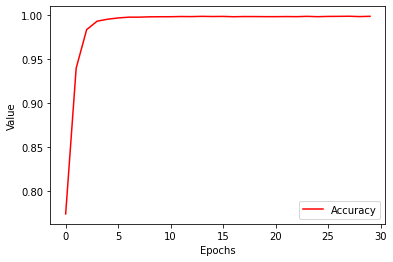

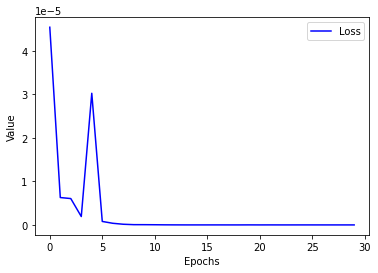

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('વર્ષો', 'N_NN'),
 ('પહેલાંની', 'JJ'),
 ('આ', 'DM_DMD'),
 ('વાત', 'N_NN'),
 ('છે', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('વર્ષો', 'N_NN'), ('પહેલાંની', 'N_NN'), ('આ', 'DM_DMD'), ('વાત', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('કમિશન', 'JJ'), ('એજન્ટ', 'N_NNP'), ('તરીકે', 'PSP'), ('કાર્ય', 'N_NN'), ('કર્યું', 'V_VM'), ('પણ', 'RP_RPD'), ('સફળતા', 'N_NN'), ('હાથ', 'N_NN'), ('લાગી', 'V_VAUX_VNP'), ('નહીં', 'RP_NEG'), ('.', 'RD_PUNC')]
[('તેમાં', 'DM_DMD'), ('મહાભારતની', 'N_NN'), ('અસર', 'N_NN'), ('વધુ', 'QT_QTF'), ('જોવા', 'V_VAUX_VNP'), ('મળે', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('ભારત', 'N_NNP'), ('પ્રાચીન', 'JJ'), ('સમયથી', 'N_NN'), ('કાચી', 'JJ'), ('તેમજ', 'CC_CCD'), ('પકવેલી', 'N_NN'), ('માટી', 'N_NN'), ('(', 'RD_SYM'), ('ટેરાકોટાનાં', 'N_NN'), (')', 'RD_SYM'), ('વાસણો', 'N_NN'), ('તેમજ', 'CC_CCD'), ('વસ્તુઓનું', 'N_NN'), ('ઉત્પાદન', 'V_VAUX_VNP'), ('કરવા', 'V_VAUX_VNP'), ('માટે', 'PSP'), ('જાણીતું', 'JJ'), ('હતું', 'V_VAUX'), ('.', 'RD_PUNC')]
[('પાટણમાંથી', 'N_NNP'), ('ઉત્પાદિત', 'JJ'), ('થતાં', 'V_VAUX_VNP'), ('રેશમી', 'N_NN'), ('વસ્ત્ર', 'N_NN'), ('(', 'RD_SYM'), ('બેવડ', 'RP_RPD

In [ ]:
dict_true['art'] = y_true
dict_pred['art'] = y_pred

## Economy

In [ ]:
path = '/content/guj_economy_sample2.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3383
Unique tags: 29
Unique characters: 105


In [ ]:
word_to_idx.keys()

dict_keys(['દેશના', 'વિકાસમાં', 'પાયાની', 'સવલતો', 'ધરાવતા', 'માળખાને', 'મુખ્ય', 'બે', 'ભાગમાં', 'વહેંચવામાં', 'આવે', 'છે', '.', 'આર્થિક', 'આંતરમાળખું', 'અને', 'સામાજિક', 'આવી', 'સેવાઓનું', 'જેમ', 'ઉત્પાદન', 'વધતું', 'જાય', 'તેમ', 'અમુક', 'હદ', 'સુધી', 'એ', 'સેવાની', 'એકમ', 'દીઠ', 'ખર્ચ', 'ઘટતું', 'જેમકે', ',', 'વીજળીના', 'ઉત્પાદનમાં', 'વધારો', 'થાય', 'તો', 'થતું', 'ઉત્પાદનખર્ચ', 'ઘટે', 'સેવાઓનો', 'લાભ', 'તેમના', 'પ્રત્યક્ષ', 'ગ્રાહકો', 'પૂરતો', 'મર્યાદિત', 'રહેતો', 'નથી', 'લાભો', 'પરોક્ષ', 'રીતે', 'સમગ્ર', 'સમાજને', 'પ્રાપ્ત', 'વિકાસ', 'સાથે', 'સેવાઓ', 'ગાઢ', 'સંકળાયેલી', 'જણાય', 'વિશ્વ', 'બેંકે', 'આપેલા', 'અંદાજ', 'પ્રમાણે', 'સેવાઓના', 'જથ્થામાં', 'થતો', '૧', 'ટકાનો', 'રાષ્ટ્રીય', 'પેદાશના', 'ટકાના', 'વધારા', 'સંકળાયેલો', 'આને', 'કારણે', 'કેટલીક', 'સેવાઓમાં', 'રોકાયેલી', 'મૂડીનું', 'માથાદીઠ', 'મૂલ્ય', 'દેશની', 'આવક', 'સમખરીદશક્તિ', 'સિદ્ધાંત', 'અનુસાર', '૧૯૯૦માં', 'વિકિસત', 'દેશોની', '૨૦,૦૦૦', 'ડૉલર', 'જેટલી', 'હતી', 'ગરીબોનો', 'વસવાટ', 'શહેરના', 'ચોક્કસ', 'વિસ્તારોમાં', 'કેન્દ્રિત',

In [ ]:
char_to_idx.keys()

dict_keys(['દ', 'ે', 'શ', 'ન', 'ા', 'વ', 'િ', 'ક', 'સ', 'મ', 'ં', 'પ', 'ય', 'ી', 'લ', 'ત', 'ો', 'ધ', 'ર', 'ળ', 'ખ', 'ુ', '્', 'બ', 'ભ', 'ગ', 'હ', 'ચ', 'આ', 'છ', '.', 'થ', 'અ', 'જ', 'ઓ', 'ઉ', 'એ', 'ઠ', 'ઘ', 'ટ', ',', 'ષ', 'ૂ', 'ઢ', 'ણ', '૧', 'ડ', '૯', '૦', '૨', 'ૉ', 'ઈ', 'ફ', 'ઊ', 'ૌ', 'ૃ', '૪', '(', ')', '૫', '-', 'ૅ', '૬', '%', '૭', '૩', 'ઔ', 'ઝ', 'O', 'N', 'G', 'C', 'ઑ', 'ઍ', 'ૈ', '?', '/', '૮', 'P', 'ઞ', 'D', ':', 'i', 's', 'n', 'v', 'e', 't', 'm', 'ઇ', '`', 'ઃ', 'ઋ', 'p', 'r', 'a', 'o', 'R', 'c', 'h', 'I', 'd', 'S', 'u', ';'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)



accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.0011054945312783577	Accuracy: 0.9324873089790344
Epoch 6 Completed,	Loss 3.0639650544136052e-06	Accuracy: 0.9965609113375345
Epoch 9 Completed,	Loss 4.8465863618692616e-08	Accuracy: 0.9988300800323486
Epoch 12 Completed,	Loss 2.070473255807078e-09	Accuracy: 0.9989035328229269
Epoch 15 Completed,	Loss 2.8233761162343995e-10	Accuracy: 0.9990272124608358
Epoch 18 Completed,	Loss 1.1502602897950354e-09	Accuracy: 0.9988949696222941
Epoch 21 Completed,	Loss 4.810194233669426e-10	Accuracy: 0.9989830851554871
Epoch 24 Completed,	Loss 3.137085961372558e-11	Accuracy: 0.9990937312444051
Epoch 27 Completed,	Loss 2.0913907180138598e-11	Accuracy: 0.9991981387138367
Epoch 30 Completed,	Loss 0.0	Accuracy: 0.9991981387138367


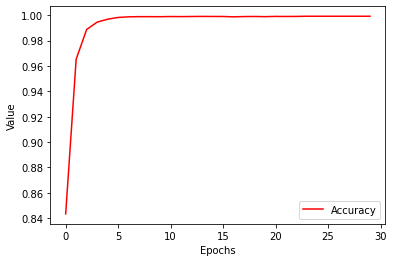

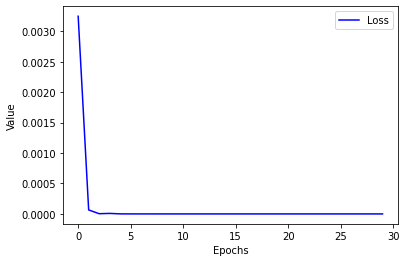

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('આંતરરાષ્ટ્રીય', 'JJ'),
 ('સ્તરે', 'N_NN'),
 ('૧૫', 'QT_QTC'),
 ('વર્ષ', 'N_NN'),
 ('કે', 'CC_CCS'),
 ('તેથી', 'PSP'),
 ('વધુ', 'QT_QTF'),
 ('વયની', 'N_NN'),
 ('વ્યક્તિઓમાં', 'N_NN'),
 ('સાક્ષર', 'JJ'),
 ('વ્યક્તિઓના', 'N_NN'),
 ('પ્રમાણને', 'N_NN'),
 ('ગણતરીમાં', 'N_NN'),
 ('લેવામાં', 'V_VAUX_VNP'),
 ('આવે', 'V_VAUX'),
 ('છે', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('આંતરરાષ્ટ્રીય', 'DM_DMD'), ('સ્તરે', 'N_NN'), ('૧૫', 'QT_QTC'), ('વર્ષ', 'N_NN'), ('કે', 'CC_CCS'), ('તેથી', 'PSP'), ('વધુ', 'QT_QTF'), ('વયની', 'N_NN'), ('વ્યક્તિઓમાં', 'V_VM'), ('સાક્ષર', 'JJ'), ('વ્યક્તિઓના', 'JJ'), ('પ્રમાણને', 'N_NN'), ('ગણતરીમાં', 'N_NN'), ('લેવામાં', 'N_NN'), ('આવે', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('૧૯૫૦', 'QT_QTC'), ('-', 'RD_PUNC'), ('૫૧', 'QT_QTC'), ('બાદ', 'PSP'), ('ભારતમાં', 'N_NNP'), ('યુનિવર્સિટીઓની', 'JJ'), ('સંખ્યામાં', 'N_NN'), ('૧૨', 'QT_QTC'), (',', 'RD_PUNC'), ('કૉલેજોની', 'JJ'), ('સંખ્યામાં', 'N_NN'), ('૨૩', 'QT_QTC'), ('અને', 'CC_CCD'), ('કૉલેજના', 'JJ'), ('પ્રવેશાર્થીઓની', 'N_NN'), ('સંખ્યામાં', 'N_NN'), ('૨૯', 'QT_QTC'), ('ગણો', 'N_NN'), ('વધારો', 'N_NN'), ('નોંધાયો', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('તંદુરસ્ત', 'JJ'), ('શ્રમિકો', 'N_NN'), ('દેશના', 'N_NN'), ('આર્થિક', 'JJ'), ('વિકાસ', 'N_NN'), ('માટેની', 'PSP'), ('પૂર્વશરત', 'N_NN'), ('ગણી', 'JJ'), ('શકાય', 'V_VAUX'), ('.', 'RD_PUNC')]
[('સ્વાસ્થ્ય', 'N_NN'), (

In [ ]:
dict_true['econo'] = y_true
dict_pred['econo'] = y_pred

## Philosophy

In [ ]:
path = '/content/guj_philosophy_sample4.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3914
Unique tags: 29
Unique characters: 78


In [ ]:
word_to_idx.keys()

dict_keys(['ભારતીય', 'તત્ત્વવિચારની', 'ગંગોત્રી', 'વેદ', 'છે', '.', 'મુખ્ય', 'અને', 'મહત્ત્વની', 'શાખાઓ', '-', 'આધારિત', 'એ', 'વેદને', 'પ્રમાણભૂત', 'માનીને', 'ચાલે', 'વેદના', 'અર્થઘટન', 'ને', 'વિસ્તરણ', 'રૂપે', 'વિકસે', 'આસ્તિક', 'દર્શનો', 'કહેવાય', 'એટલે', 'ઈશ્વરમાં', 'માનનાર', 'એવો', 'અર્થ', 'અહીં', 'નથી', 'આ', 'બધા', 'જગતકર્તા', 'માનનારાં', 'ન', 'એનાથી', 'ફંટાઈને', 'પ્રવર્તનાર', 'તે', 'નાસ્તિક', 'જેમકે', 'ચાર્વાક', ',', 'બૌદ્ધ', 'જૈન', 'વર્ગીકરણ', 'તત્ત્વવિચારના', 'કેન્દ્રમાં', 'તેનું', 'જ', 'સમર્થન', 'કરે', 'ભારતનું', 'પ્રાચીનતમ', 'સાહિત્ય', 'વેદનો', 'જ્ઞાન', 'થાય', 'ભારતમાં', 'તત્ત્વદર્શન', 'ઉપરાંત', 'ભાષા', 'સંગીત', 'ગણિત', 'ખગોળવિદ્યા', 'આદિ', 'અનેક', 'ક્ષેત્રોમાં', 'જે', 'કંઈ', 'વિચારણાઓ', 'થઈ', 'તેનાં', 'બીજ', 'વેદમાં', 'જોવામાં', 'આવે', 'રીતે', 'એનું', '`', 'નામ', 'સાર્થક', 'ઠરે', 'કોઈ', 'વ્યક્તિ', 'કે', 'પુરુષવિશેષનું', 'સર્જન', 'તેથી', 'એને', 'અનાદિ', 'અપૌરુષેય', 'ગણવામાં', 'ઈશ્વરપ્રણીત', 'હોવાનું', 'પણ', 'પરમાત્મા', 'પાસેથી', 'ઋષિઓએ', 'સાંભળેલા', 'મંત્રો', 'દિવ્યતાની', 'આર

In [ ]:
char_to_idx.keys()

dict_keys(['ભ', 'ા', 'ર', 'ત', 'ી', 'ય', '્', 'વ', 'િ', 'ચ', 'ન', 'ગ', 'ં', 'ો', 'ે', 'દ', 'છ', '.', 'મ', 'ુ', 'ખ', 'અ', 'હ', 'શ', 'ઓ', '-', 'આ', 'ધ', 'એ', 'પ', 'ણ', 'ૂ', 'લ', 'થ', 'ઘ', 'ટ', 'સ', 'ક', 'ઈ', 'બ', 'જ', 'ફ', ',', 'ૌ', 'ૈ', 'ઞ', 'ઉ', 'ષ', 'ળ', '`', 'ઠ', 'ઋ', '(', ')', ':', 'ઐ', 'ૃ', 'ડ', ';', 'ઇ', '૬', '૦', '૨', '૫', '૪', '૮', '૯', '૧', '૩', 'ઊ', 'ઢ', 'ઝ', '?', 'ૉ', '!', '૭', 'ઃ', 'ઔ'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.00012153219260350549	Accuracy: 0.9150839447975159
Epoch 6 Completed,	Loss 5.383929912265254e-07	Accuracy: 0.9961131612459818
Epoch 9 Completed,	Loss 4.897400233498198e-08	Accuracy: 0.9980061650276184
Epoch 12 Completed,	Loss 1.06242370456755e-09	Accuracy: 0.9984642267227173
Epoch 15 Completed,	Loss 2.7605863983648504e-09	Accuracy: 0.9985210299491882
Epoch 18 Completed,	Loss 3.346225264470407e-11	Accuracy: 0.9985475142796835
Epoch 21 Completed,	Loss 1.171178570791298e-10	Accuracy: 0.9984697103500366
Epoch 24 Completed,	Loss 1.171178640180237e-10	Accuracy: 0.9985311428705851
Epoch 27 Completed,	Loss 1.1209771548503777e-09	Accuracy: 0.9986260135968527
Epoch 30 Completed,	Loss 0.0	Accuracy: 0.9986669421195984


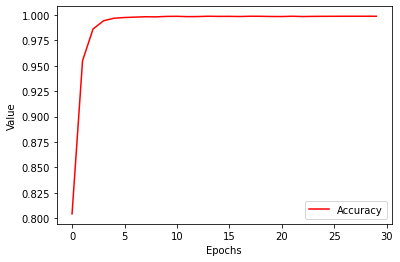

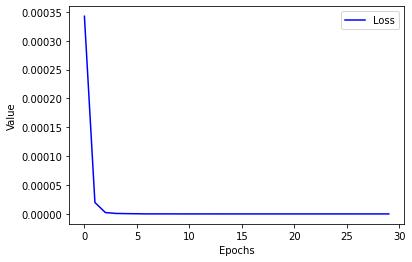

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('વેદને', 'N_NNP'),
 ('પ્રમાણભૂત', 'JJ'),
 ('ન', 'RP_NEG'),
 ('માનનાર', 'V_VAUX_VNP'),
 ('અને', 'CC_CCD'),
 ('એનાથી', 'DM_DMD'),
 ('ફંટાઈને', 'V_VAUX_VNP'),
 ('પ્રવર્તનાર', 'V_VAUX_VNP'),
 ('દર્શનો', 'N_NN'),
 ('તે', 'DM_DMD'),
 ('નાસ્તિક', 'JJ'),
 ('દર્શનો', 'N_NN'),
 ('કહેવાય', 'V_VM'),
 ('છે', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('વેદને', 'N_NNP'), ('પ્રમાણભૂત', 'JJ'), ('ન', 'RP_NEG'), ('માનનાર', 'V_VAUX_VNP'), ('અને', 'CC_CCD'), ('એનાથી', 'DM_DMD'), ('ફંટાઈને', 'JJ'), ('પ્રવર્તનાર', 'JJ'), ('દર્શનો', 'N_NN'), ('તે', 'DM_DMD'), ('નાસ્તિક', 'JJ'), ('દર્શનો', 'N_NN'), ('કહેવાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એના', 'DM_DMD'), ('બે', 'QT_QTC'), ('ભાગ', 'N_NN'), ('પડે', 'N_NN'), ('છે', 'V_VAUX'), ('-', 'RD_PUNC'), ('પૂર્વઆર્ચિક', 'N_NN'), ('અને', 'CC_CCD'), ('ઉત્તરઆર્ચિક', 'N_NN'), ('.', 'RD_PUNC')]
[('એમાં', 'DM_DMD'), ('પણ', 'CC_CCD'), ('ઋગ્વેદની', 'N_NNP'), ('કેટલીક', 'QT_QTF'), ('ઋચાઓ', 'N_NN'), ('ફરીને', 'N_NN'), ('દર્શન', 'N_NN'), ('દે', 'PSP'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એ', 'DM_DMD'), ('ઉપરાંત', 'PSP'), ('યજ્ઞક્રિયાઓ', 'N_NN'), ('પાછળની', 'N_NN'), ('ભાવનાઓ', 'N_NN'), ('પણ', 'CC_CCD'), ('સ્ફૂટ', 'N_NN'), ('કરવામાં', 'JJ'), ('આવી', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('વ્યાકરણ', 'JJ'), (':', 'RD_PUNC'), ('અત્યારે', 'PR_PRL'), ('પાણિનિનું', 'N_NN'), ('જ', 'RP_RPD'), (

In [ ]:
dict_true['philo'] = y_true
dict_pred['philo'] = y_pred

## Relegion

In [ ]:
path = '/content/guj_religion_sample5.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 4242
Unique tags: 29
Unique characters: 81


In [ ]:
word_to_idx.keys()

dict_keys(['શિવજીની', 'બે', 'અવસ્થાઓ', 'માનવામાં', 'આવી', 'છે', '.', 'તેમાંથી', 'એક', 'સમાધિ', 'અને', 'બીજી', 'તાંડવ', 'અથવા', 'લાસ્ય', 'નૃત્ય', 'અવસ્થા', 'અર્થાત્', 'નિર્ગુણ', 'નૃત્યાવસ્થા', 'એટલે', 'સગુણ', 'એકાદી', 'નિશ્ચિત', 'ઘટના', 'વિષય', 'અભિવ્યક્ત', 'કરવા', 'માટે', 'જે', 'અંગચાલન', 'કરવામાં', 'આવે', 'તેને', 'નટન', 'નાટ્ય', 'એવી', 'સંજ્ઞા', 'આ', 'કરે', 'તે', 'નટ', 'શિવજી', 'એ', 'આદ્યનટ', 'શ્રદ્ધા', 'હોવાથી', 'તેમને', '`', 'નટરાજનું', 'બિરુદ', 'મળ્યું', 'બ્રહ્માંડ', 'નટરાજની', 'નૃત્યશાળા', 'તેઓ', 'રીતે', 'નર્તક', ',', 'તેના', 'સાક્ષી', 'પણ', 'નટરાજ', 'કલ્પના', 'પાછળની', 'ભૂમિકા', 'સૃષ્ટિ', 'સ્થિતિ', 'સંહાર', 'તિરોભાવ', '(', 'માયાનું', 'આવરણ', ')', 'અનુગ્રહ', 'પાંચ', 'ઈશ્વરી', 'ક્રિયાઓનું', 'દ્યોતક', 'શિવજીએ', 'પોતે', 'પહેલા', 'કરેલું', 'ઉદ્વત', 'નૃત્યનું', 'સ્મરણ', 'કરીને', 'પોતાના', 'ગણોમાંના', 'અગ્રણી', 'રહેલા', 'તંડૂ', 'દ્વારા', 'ભરતમુનિને', 'બતાવ્યું', 'લાસ્ય:', 'સ્ત્રી', 'તેમાં', 'હાથ', 'મુક્ત', 'હોય', 'તંડુએ', 'કરી', 'એવું', 'સમજીને', 'ભરત', 'ઈત્યાદિ', 'મુનિઓએ', 'માનવોને', '

In [ ]:
char_to_idx.keys()

dict_keys(['શ', 'િ', 'વ', 'જ', 'ી', 'ન', 'બ', 'ે', 'અ', 'સ', '્', 'થ', 'ા', 'ઓ', 'મ', 'ં', 'આ', 'છ', '.', 'ત', 'એ', 'ક', 'ધ', 'ડ', 'લ', 'ય', 'ૃ', 'ર', 'ગ', 'ુ', 'ણ', 'ટ', 'દ', 'ચ', 'ઘ', 'ષ', 'ભ', 'ઞ', 'હ', 'ો', '`', 'ળ', ',', 'પ', 'ૂ', '(', ')', 'ઈ', 'ઉ', ':', 'ખ', 'ૈ', 'ૌ', 'ફ', 'ઢ', '-', '૧', '૪', 'ઝ', 'ઠ', '૩', '૫', '?', '૨', '૦', '+', 'ઔ', 'ઊ', 'ઋ', 'ઃ', '!', '૬', '૯', '૮', 'ઐ', '૭', 'ૉ', '/', ';', 'ઇ', "'"])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)



accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.0005443004805177528	Accuracy: 0.8889872034390768
Epoch 6 Completed,	Loss 1.2266227334597108e-06	Accuracy: 0.9936323960622152
Epoch 9 Completed,	Loss 2.5726243239413787e-07	Accuracy: 0.996526817480723
Epoch 12 Completed,	Loss 6.460750601178233e-09	Accuracy: 0.9970972935358683
Epoch 15 Completed,	Loss 6.331917749384057e-09	Accuracy: 0.9970853328704834
Epoch 18 Completed,	Loss 7.014194040403746e-10	Accuracy: 0.9971706867218018
Epoch 21 Completed,	Loss 2.445315998300668e-10	Accuracy: 0.9973567525545756
Epoch 24 Completed,	Loss 8.36556131080431e-11	Accuracy: 0.997393806775411
Epoch 27 Completed,	Loss 2.3166135676433441e-10	Accuracy: 0.9976169268290201
Epoch 30 Completed,	Loss 1.9305146023440578e-11	Accuracy: 0.997699499130249


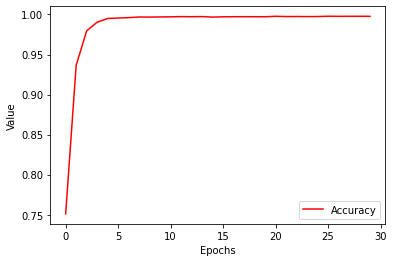

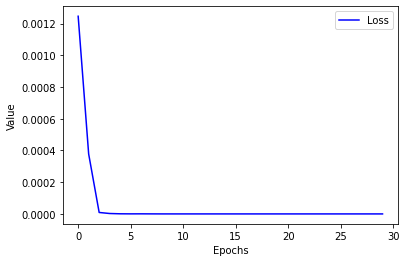

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('આ', 'DM_DMD'),
 ('નૃત્યના', 'N_NN'),
 ('સાત', 'QT_QTC'),
 ('પ્રકાર', 'N_NN'),
 ('છે', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('આ', 'DM_DMD'), ('નૃત્યના', 'N_NN'), ('સાત', 'QT_QTC'), ('પ્રકાર', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('જ્યાં', 'N_NST'), ('જીવોનો', 'N_NST'), ('અહંકાર', 'N_NN'), ('ભસ્મસાત', 'PSP'), ('થઈ', 'V_VM'), ('જાય', 'V_VAUX'), ('છે', 'V_VAUX'), (',', 'RD_PUNC'), ('એવી', 'JJ'), ('અવસ્થાનું', 'N_NN'), ('પ્રતીક', 'N_NN'), ('એટલે', 'PSP'), ('સ્મશાનભૂમિ', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('લોકવાણી', 'JJ'), ('એવી', 'JJ'), ('છે', 'V_VAUX'), ('કે', 'CC_CCS'), ('`', 'RD_PUNC'), ('પ્રભુનો', 'N_NN'), ('બન્યો', 'N_NN'), ('તે', 'DM_DMD'), ('પોઠિયો', 'N_NN'), ('.', 'RD_PUNC'), ('`', 'RD_PUNC')]
[('અને', 'CC_CCD'), ('તેનાથી', 'DM_DMD'), ('સિવાતું', 'DM_DMD'), ('નથી', 'RP_NEG'), ('.', 'RD_PUNC')]
[('જેમના', 'PR_PRL'), ('મસ્તક', 'N_NN'), ('ઉપર', 'PSP'), ('મુગટ', 'N_NN'), ('જોવા', 'V_VAUX_VNP'), ('મળે', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('જેમને', 'JJ'), ('ત્રણ', 'QT_QTC'), ('નેત્રો', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('નોંધપાત્ર', 'N_NN'), ('બાબત', 'N_NN'), ('એ',

In [ ]:
dict_true['relegion'] = y_true
dict_pred['relegion'] = y_pred

## entern

In [ ]:
path = '/content/guj_entertainment_sample3.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3715
Unique tags: 28
Unique characters: 64


In [ ]:
word_to_idx.keys()

dict_keys(['શુકલની', 'ફેવર', 'કરી', 'એ', 'ભૂલ', 'થઈ', '.', 'ખરેખર', 'તો', 'સારું', 'કામ', 'કરે', 'છે', 'ને', 'વળી', 'ઉપયોગી', 'માણસ', 'પણ', 'ખરો', '-', 'એવું', 'સાહેબ', 'આગળ', 'બોલવું', 'જ', 'નહોતું', 'જોઈતું', 'બોલાઈ', 'ગયું', 'એને', 'પ્રમોશન', 'મળ્યું', 'એક', 'દલિતના', 'હાથે', 'સવર્ણનો', 'ઉદ્ધાર', 'થયો', '!', 'જોકે', 'હું', 'ન', 'બોલત', 'ય', 'એનું', 'થવાનું', 'હતું', 'પછી', 'બૂરા', 'શું', 'બનવું', '?', 'કામનો', 'ડ્રાફ્ટિંગ', 'તમે', 'જેવું', 'વિચારતા', 'હો', 'લખી', 'આપે', 'અને', 'સહેજ', 'છેકછાક', 'વગર', 'ગમે', 'એમ', 'મૂળે', 'બામણનો', 'દીકરો', ',', 'ઘરના', 'સંસ્કાર', 'એટલે', 'જાણે', 'સરસ્વતી', 'જીભે', 'આમ', 'એના', 'વખાણ', 'કરવા', 'જોઈએ', '`', 'રૂલબુકની', 'વિરુદ્ધની', 'વાત', 'ચાવડાએ', 'બધાની', 'વચ્ચે', 'કહ્યું', 'કે', 'આ', 'સોલંકી', 'પેલી', 'ચોટલીના', 'જ્યાં', 'હોય', 'ત્યાં', 'કર્યા', 'આપણી', 'રૂલબુકનો', 'છડેચોક', 'ભંગ', 'ના', 'ચાલે', 'મહેતાએ', 'ટાપસી', 'પુરાવી', 'હતી', 'હા', 'પરમ', 'દિવસે', 'એની', 'ઑફિસે', 'ગયો', 'હતો', 'મેં', 'કાને', 'સાંભળ્યું', 'સગી', 'આંખે', 'જોયું', 'બધા', 'કાગડાન

In [ ]:
char_to_idx.keys()

dict_keys(['શ', 'ુ', 'ક', 'લ', 'ન', 'ી', 'ફ', 'ે', 'વ', 'ર', 'એ', 'ભ', 'ૂ', 'થ', 'ઈ', '.', 'ખ', 'ત', 'ો', 'સ', 'ા', 'ં', 'મ', 'છ', 'ળ', 'ઉ', 'પ', 'ય', 'ગ', 'ણ', '-', 'હ', 'બ', 'આ', 'જ', '્', 'દ', 'િ', 'ધ', '!', '?', 'ડ', 'ટ', 'ચ', 'અ', ',', 'ઘ', '`', 'ઑ', 'ઊ', 'ઝ', ':', 'ઢ', 'ઓ', 'ઠ', 'ૌ', 'ૃ', 'ૈ', 'ષ', 'ૉ', 'ૅ', 'ઞ', ';', 'ઔ'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)



accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.0009857121331151575	Accuracy: 0.8849679629007975
Epoch 6 Completed,	Loss 1.8131409357617183e-06	Accuracy: 0.9907755653063456
Epoch 9 Completed,	Loss 8.476890987670534e-07	Accuracy: 0.9939597050348917
Epoch 12 Completed,	Loss 8.578369895910025e-08	Accuracy: 0.9944708148638407
Epoch 15 Completed,	Loss 2.3536000629912717e-08	Accuracy: 0.9948690136273702
Epoch 18 Completed,	Loss 3.577860563375168e-09	Accuracy: 0.9948826630910238
Epoch 21 Completed,	Loss 1.5263263171879277e-08	Accuracy: 0.9951732556025187
Epoch 24 Completed,	Loss 6.177638215791129e-10	Accuracy: 0.9953769048055013
Epoch 27 Completed,	Loss 3.024470118795364e-10	Accuracy: 0.9954283833503723
Epoch 30 Completed,	Loss 5.1480383035188794e-11	Accuracy: 0.9953565796216329


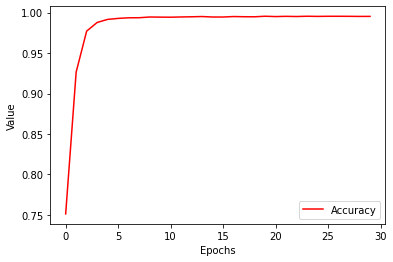

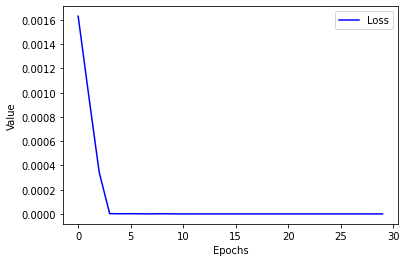

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('ગમે', 'PSP'),
 ('એમ', 'PSP'),
 ('પણ', 'RP_RPD'),
 ('મૂળે', 'JJ'),
 ('તો', 'RP_RPD'),
 ('બામણનો', 'N_NN'),
 ('દીકરો', 'N_NN'),
 (',', 'RD_PUNC'),
 ('ને', 'CC_CCD'),
 ('ઘરના', 'N_NN'),
 ('સંસ્કાર', 'N_NN'),
 ('એટલે', 'PSP'),
 ('જાણે', 'PSP'),
 ('સરસ્વતી', 'N_NN'),
 ('તો', 'RP_RPD'),
 ('જીભે', 'N_NN'),
 ('જ', 'RP_RPD'),
 ('-', 'RD_PUNC'),
 ('આમ', 'PSP'),
 ('એના', 'PR_PRP'),
 ('વખાણ', 'N_NN'),
 ('ન', 'RP_NEG'),
 ('કરવા', 'V_VAUX_VNP'),
 ('જોઈએ', 'V_VAUX'),
 (',', 'RD_PUNC'),
 ('એ', 'PR_PRP'),
 ('`', 'RD_PUNC'),
 ('રૂલબુકની', 'N_NN'),
 ('`', 'RD_PUNC'),
 ('વિરુદ્ધની', 'PSP'),
 ('વાત', 'N_NN'),
 ('થઈ', 'V_VM'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('ગમે', 'PSP'), ('એમ', 'PSP'), ('પણ', 'RP_RPD'), ('મૂળે', 'JJ'), ('તો', 'RP_RPD'), ('બામણનો', 'N_NN'), ('દીકરો', 'N_NN'), (',', 'RD_PUNC'), ('ને', 'CC_CCD'), ('ઘરના', 'N_NN'), ('સંસ્કાર', 'N_NN'), ('એટલે', 'PSP'), ('જાણે', 'PSP'), ('સરસ્વતી', 'N_NN'), ('તો', 'RP_RPD'), ('જીભે', 'N_NN'), ('જ', 'RP_RPD'), ('-', 'RD_PUNC'), ('આમ', 'PSP'), ('એના', 'PR_PRP'), ('વખાણ', 'N_NN'), ('ન', 'RP_NEG'), ('કરવા', 'V_VAUX_VNP'), ('જોઈએ', 'V_VM'), (',', 'RD_PUNC'), ('એ', 'DM_DMD'), ('`', 'RD_PUNC'), ('રૂલબુકની', 'N_NN'), ('`', 'RD_PUNC'), ('વિરુદ્ધની', 'V_VAUX_VNP'), ('વાત', 'N_NN'), ('થઈ', 'V_VM'), ('.', 'RD_PUNC')]
[('ચકલા', 'N_NN'), ('ચૂંથ્યા', 'N_NST'), ('.', 'RD_PUNC')]
[('`', 'RD_PUNC'), ('બહુ', 'QT_QTF'), ('ડાહ્યા', 'JJ'), (',', 'RD_PUNC'), ('બોલ્યા', 'N_NN'), ('ક્યારે', 'N_NST'), ('?', 'RD_PUNC'), ('`', 'RD_PUNC')]
[('હું', 'PR_PRP'), ('કંઈ', 'DM_DMI'), ('મહેતાફેતાની', 'N_NN'), ('જેમ', 'PSP'), ('ગળામાં', 'N_NN'), ('દોરડું', 'N_NN'), ('લટકાવી', 'V_VM'), ('મંત્રીઓને', 'N_NN'), ('દેખાડતો', 'N_NN')

In [ ]:
dict_true['entern'] = y_true
dict_pred['entern'] = y_pred

## scie

In [ ]:
path = '/content/guj_science and technology_sample6.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 5544
Unique tags: 31
Unique characters: 131


In [ ]:
word_to_idx.keys()

dict_keys(['વસ્તી', 'વધારાથી', 'સર્જાતું', 'દબાણ', 'મુખ્ય', 'બે', 'ચાવીરૂપ', 'પરિબળમાં', 'પ્રતિબિંબિત', 'થાય', 'છે', '.', 'વધારાનો', 'દર', 'અને', 'વિશ્વની', 'કુલ', 'વસ્તીમાં', 'વર્ષે', 'થતો', 'વધારો', 'છેલ્લા', 'કેટલાક', 'દાયકાઓથી', 'ઘટી', 'રહ્યો', ',', 'જ્યારે', 'ભવિષ્યમાં', 'પણ', 'રહેશે', '૧૯૯૦ના', 'દાયકામાં', 'અત્યાર', 'સુધીમાં', 'સર્વાધિક', 'એવી', 'લગભગ', '૧૦', 'કરોડ', 'માણસોની', 'વાર્ષિક', 'વૃદ્ધિ', 'થઈ', 'રહી', 'માનવ', 'સંખ્યામાં', 'આવો', 'અભૂતપૂર્વ', 'ઝડપી', 'તેની', 'વહેંચણીની', 'તરાહ', 'વિકાસની', 'પ્રક્રિયા', 'આડે', 'ગંભીર', 'અવરોધ', 'સર્જે', 'ખાસ', 'કરીને', 'વિકાસગામી', 'દેશોના', 'આર્થિક', 'આધાર', 'સમા', 'કુદરતી', 'સાધનોના', 'પાયા', 'ઉપર', 'અસહ્ય', 'બોજ', 'વધારે', 'વધુમાં', 'વિકાસ', 'પામતા', 'સમાજને', 'સંતોષવા', 'આયોજન', 'સાધવાની', 'સરકારની', 'ક્ષમતા', 'તે', 'પોતાનો', 'પ્રચંડ', 'પ્રભાવ', 'જમાવે', 'વળી', 'એકાએક', 'ફાટી', 'નીકળતી', 'વધુ', 'વસ્તીને', 'મૂળભૂત', 'સેવાઓ', 'સગવડોના', 'રૂપમાં', 'અર્ધસામાજિક', 'માળખું', 'પૂરું', 'પાડવાનો', 'પૂરતો', 'સમય', 'સુદ્ધાં', 'મળતો', 'નથી', 'તમા

In [ ]:
char_to_idx.keys()

dict_keys(['વ', 'સ', '્', 'ત', 'ી', 'ધ', 'ા', 'ર', 'થ', 'જ', 'ુ', 'ં', 'દ', 'બ', 'ણ', 'મ', 'ખ', 'ય', 'ે', 'ચ', 'ૂ', 'પ', 'િ', 'ળ', 'છ', '.', 'ન', 'ો', 'અ', 'શ', 'ક', 'લ', 'ષ', 'ટ', 'ઓ', 'ઘ', 'હ', ',', 'ભ', '૧', '૯', '૦', 'એ', 'ગ', 'ડ', 'ૃ', 'ઈ', 'આ', 'ઝ', 'ઉ', 'ફ', 'ઊ', 'ઔ', 'ઠ', 'ૈ', '૫', '૩', '`', '?', '-', 'ૌ', '૨', '૬', '૮', ';', '૪', '૭', 'ઢ', 'ઞ', '(', 'G', 'F', 'T', 'o', 'u', 'r', 'n', 'e', 'c', 'h', ')', 'ઃ', 'p', 't', 'i', 'a', 'm', 'ઇ', 'I', 'd', 'P', 's', 'f', 'R', 'S', 'g', 'y', 'N', 'A', 'l', 'M', 'D', 'C', 'E', '&', 'v', 'b', 'O', '/', 'U', 'ઋ', ':', 'B', '1', 'ૉ', 'x', '2', '%', 'q', 'k', 'W', 'w', '=', 'J', 'Q', 'V', 'H', 'ૅ', 'ઑ', '!', 'ઍ'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.0008421482343692333	Accuracy: 0.9045925339063009
Epoch 6 Completed,	Loss 1.8120282447853242e-06	Accuracy: 0.9952013691266378
Epoch 9 Completed,	Loss 3.33572948226409e-06	Accuracy: 0.9977527062098185
Epoch 12 Completed,	Loss 8.002611462387677e-08	Accuracy: 0.9982572595278422
Epoch 15 Completed,	Loss 2.800212291672229e-08	Accuracy: 0.9983518123626709
Epoch 18 Completed,	Loss 4.067592781116976e-09	Accuracy: 0.9985036452611288
Epoch 21 Completed,	Loss 4.705629057707069e-11	Accuracy: 0.9983922441800436
Epoch 24 Completed,	Loss 2.002471639894754e-09	Accuracy: 0.998400092124939
Epoch 27 Completed,	Loss 2.875659247762267e-10	Accuracy: 0.9983209768931071
Epoch 30 Completed,	Loss 1.694016242096789e-09	Accuracy: 0.9983344276746114


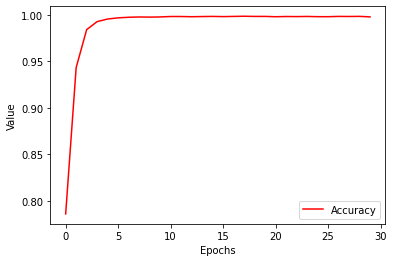

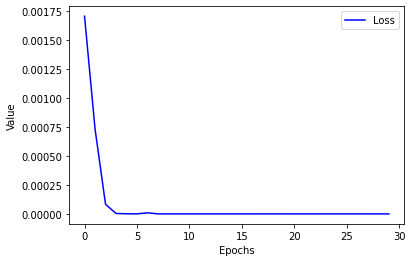

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('આ', 'DM_DMD'),
 ('દેશો', 'N_NN'),
 ('ઓઝોનના', 'N_NN'),
 ('પડને', 'N_NN'),
 ('થયેલા', 'V_VAUX_VNP'),
 ('નુક્સાન', 'N_NN'),
 ('માટે', 'PSP'),
 ('અને', 'CC_CCD'),
 ('વાતાવરણમાં', 'N_NN'),
 ('વધેલા', 'V_VAUX_VNP'),
 ('એસિડના', 'N_NN'),
 ('પ્રમાણ', 'N_NN'),
 ('માટે', 'PSP'),
 ('સૌથી', 'JJ'),
 ('વધુ', 'QT_QTF'),
 ('પ્રમાણમાં', 'N_NN'),
 ('જવાબદાર', 'JJ'),
 ('છે', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('આ', 'DM_DMD'), ('દેશો', 'N_NN'), ('ઓઝોનના', 'N_NN'), ('પડને', 'N_NN'), ('થયેલા', 'N_NN'), ('નુક્સાન', 'N_NN'), ('માટે', 'PSP'), ('અને', 'CC_CCD'), ('વાતાવરણમાં', 'N_NN'), ('વધેલા', 'N_NN'), ('એસિડના', 'PSP'), ('પ્રમાણ', 'N_NN'), ('માટે', 'PSP'), ('સૌથી', 'JJ'), ('વધુ', 'QT_QTF'), ('પ્રમાણમાં', 'N_NN'), ('જવાબદાર', 'JJ'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('ચીન', 'PR_PRL'), ('અને', 'CC_CCD'), ('ભારતના', 'N_NNP'), ('કિસ્સામાં', 'QT_QTF'), ('વસ્તીવધારાના', 'N_NN'), ('અંદાજોમાં', 'N_NN'), ('કરાયેલો', 'PSP'), ('સુધારો', 'N_NN'), ('આ', 'DM_DMD'), ('વધારાના', 'JJ'), ('અડધા', 'JJ'), ('કરતાં', 'JJ'), ('યે', 'RP_RPD'), ('વધુ', 'QT_QTF'), ('હિસ્સો', 'N_NN'), ('ધરાવે', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('વિશ્વમાં', 'N_NN'), ('અન્યત્ર', 'JJ'), ('ક્યાંયે', 'JJ'), ('જોવા', 'N_NN'), ('મળે', 'V_VM'), ('એથી', 'PSP'), ('સવિશેષ', 'JJ'), ('પ્રકારે', 'N_NN'), ('પાણી', 'N_NN'), ('માટે', 'PSP'), ('અહીં', 'N_NST'), ('ભારે', 'JJ'), ('પડાપડી', 'N_NN'), ('છે', 'V_VAUX'), (',', 'RD_PUNC'), ('અને'

In [ ]:
dict_true['sci'] = y_true
dict_pred['sci'] = y_pred

# Each corpus adam LSTM

In [ ]:
Acc_plot = []
Loss_plot = []
precision_plot = []
f1score_plot = []

dict_true = {}
dict_pred = {}

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

['DM_DMD', 'JJ', 'JJ', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NNP', 'RP_RPD', 'N_NN', 'PSP', 'PSP', 'N_NN', 'N_NNP', 'V_VM', 'DM_DMD', 'N_NN', 'RP_NEG', 'V_VAUX', 'RD_PUNC', 'CC_CCS', 'PR_PRP', 'JJ', 'N_NN', 'N_NN', 'PSP', 'JJ', 'V_VM', 'V_VAUX', 'RP_NEG', 'RD_PUNC', 'N_NNP', 'N_NNP', 'JJ', 'N_NN', 'N_NN', 'N_NNP', 'JJ', 'V_VAUX_VNP', 'N_NNP', 'N_NN', 'N_NN', 'V_VM', 'V_VAUX', 'V_VAUX', 'RD_PUNC', 'N_NNP', 'N_NNP', 'QT_QTC', 'PSP', 'N_NN', 'CC_CCD', 'QT_QTC', 'JJ', 'N_NN', 'N_NN', 'QT_QTO', 'N_NN', 'RP_RPD', 'PSP', 'V_VM', 'RD_PUNC', 'JJ', 'N_NN', 'N_NN', 'QT_QTC', 'N_NN', 'DM_DMD', 'N_NN', 'N_NN', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NN', 'QT_QTF', 'N_NN', 'N_NN', 'V_VM', 'V_VAUX', 'JJ', 'N_NN', 'N_NNP', 'N_NN', 'N_NN', 'QT_QTC', 'N_NN', 'CC_CCD', 'N_NNP', 'N_NN', 'N_NN', 'QT_QTC', 'N_NN', 'V_VM', 'V_VAUX', 'RD_PUNC', 'N_NST', 'N_NNP', 'N_NNP', 'RP_RPD', 'QT_QTC', 'N_NN', 'JJ', 'N_NN', 'PSP', 'JJ', 'V_VAUX_VNP', 'N_NN', 'V_VM', 'V_VAUX', 'CC_CCD', 'PSP', 'PR_PRP', 'N_NN', 'V_VAUX_VNP', 'N_NN', 'Q

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(dict_true.keys())

dict_keys(['sports', 'art', 'econo', 'philo', 'relegion', 'entern', 'sci'])


## sports

In [ ]:
path = '/content/guj_sports_sample7.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 4269
Unique tags: 29
Unique characters: 107


In [ ]:
word_to_idx.keys()

dict_keys(['ભારતના', 'ટેસ્ટ', 'ઇતિહાસની', 'ઑસ્ટ્રેલિયા', 'સામે', 'વિકેટની', 'રીતે', 'સૌથી', 'મોટી', 'જીત', '.', 'ભારતનો', 'આઠ', 'વિકેટથી', 'ઐતિહાસિક', 'વિજય', 'ચેન્નાઈ', 'તારીખ', '૨૬', 'કેપ્ટન', 'ધોનીની', '૨૨૪', 'રનની', 'મેરેથોન', 'ઈનિંગની', 'મદદથી', 'ભારતે', 'સામેની', 'ચેન્નાઈમાં', 'રમાયેલી', 'પ્રથમ', 'ટેસ્ટમાં', 'મેળવી', 'લીધો', 'હતો', 'આજે', 'પાંચમા', 'અને', 'આખરી', 'દિવસે', 'ઑસ્ટ્રેલિયાની', 'બીજી', 'ઈનિંગ', '૨૪૧', 'રનમાં', 'સમેટાઈ', 'હતી', 'જે', 'પછી', 'જીતવા', 'માટેના', '૫૦', 'રનના', 'પડકારને', 'લંચની', '૪૦', 'મિનિટ', 'અગાઉ', 'જ', '૧૧.૩', 'ઓવરમાં', 'બે', 'વિકેટ', 'ગુમાવીને', 'જીતી', 'ધોનીને', 'મેન', 'ઓફ', 'ધ', 'મેચ', 'જાહેર', 'કરવામાં', 'આવ્યો', 'આ', 'સાથે', 'મેચોના', 'ઇતિહાસનો', 'મોટા', 'અંતરનો', 'મેળવ્યો', 'ચાર', 'ટેસ્ટની', 'શ્રેણીમાં', '૧-૦થી', 'સરસાઈ', 'પ્રાપ્ત', 'કરી', 'હવે', 'માર્ચથી', 'હૈદરાબાદમાં', 'ટેસ્ટનો', 'પ્રારંભ', 'થશે', 'ધોનીએ', 'ભારતીય', 'ઇતિહાસના', 'સફળ', 'તરીકે', 'ગાંગુલીના', 'રેકોર્ડની', 'બરોબરી', 'લીધી', 'ગાંગુલીએ', '૪૯', 'કેપ્ટન્સી', 'કરતાં', '૨૧', 'અપાવ્યા', 

In [ ]:
char_to_idx.keys()

dict_keys(['ભ', 'ા', 'ર', 'ત', 'ન', 'ટ', 'ે', 'સ', '્', 'ઇ', 'િ', 'હ', 'ી', 'ઑ', 'લ', 'ય', 'મ', 'વ', 'ક', 'ૌ', 'થ', 'ો', 'જ', '.', 'આ', 'ઠ', 'ઐ', 'ચ', 'ઈ', 'ખ', '૨', '૬', 'પ', 'ધ', '૪', 'ં', 'ગ', 'દ', 'ળ', 'અ', 'બ', '૧', 'છ', '૫', '૦', 'ડ', 'ઉ', '૩', 'ઓ', 'ુ', 'ફ', 'શ', 'ણ', '-', 'ૈ', 'એ', '૯', 'ૂ', '૮', '૭', 'ઘ', 'ષ', 'ઝ', 'ઊ', '`', 'ઞ', '(', ',', 'ઢ', 'ૃ', 'ઃ', '/', ':', 'ૉ', 'ૅ', 'F', 'I', 'A', ')', 'ઍ', 'C', 'R', 'E', 'K', 'T', '!', 'W', 'S', 'o', 'r', 'e', 'c', 't', 'a', 'n', 'd', 'i', 'g', 'p', 's', 'D', 'f', 'v', 'H', 'ઋ', '?', 'x'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.0008956725747945408	Accuracy: 0.8016550540924072
Epoch 6 Completed,	Loss 0.000882534795285513	Accuracy: 0.9091350436210632
Epoch 9 Completed,	Loss 0.0006466042007862901	Accuracy: 0.9252671202023824
Epoch 12 Completed,	Loss 0.0018445111345499754	Accuracy: 0.9326679507891337
Epoch 15 Completed,	Loss 0.0009917432287972854	Accuracy: 0.9366175333658854
Epoch 18 Completed,	Loss 0.0003704878884794501	Accuracy: 0.9424407879511515
Epoch 21 Completed,	Loss 0.0011696795663738158	Accuracy: 0.942703127861023
Epoch 24 Completed,	Loss 0.0003345570260696225	Accuracy: 0.9473382830619812
Epoch 27 Completed,	Loss 0.00029494776405651163	Accuracy: 0.9461416006088257
Epoch 30 Completed,	Loss 0.0001384433670556795	Accuracy: 0.9487098256746928


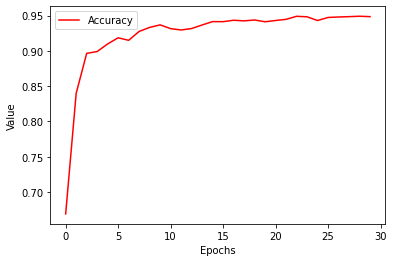

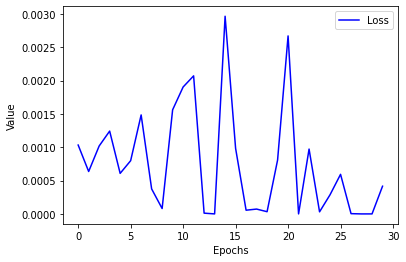

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('ગાંગુલીએ', 'N_NNP'),
 ('૪૯', 'QT_QTC'),
 ('ટેસ્ટમાં', 'N_NN'),
 ('કેપ્ટન્સી', 'N_NN'),
 ('કરતાં', 'V_VAUX_VNP'),
 ('ભારતે', 'N_NNP'),
 ('૨૧', 'QT_QTC'),
 ('વિજય', 'N_NN'),
 ('અપાવ્યા', 'V_VM'),
 ('હતા', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('ગાંગુલીએ', 'N_NNP'), ('૪૯', 'QT_QTC'), ('ટેસ્ટમાં', 'N_NN'), ('કેપ્ટન્સી', 'N_NN'), ('કરતાં', 'V_VAUX_VNP'), ('ભારતે', 'N_NNP'), ('૨૧', 'QT_QTC'), ('વિજય', 'N_NNP'), ('અપાવ્યા', 'N_NNP'), ('હતા', 'V_VAUX'), ('.', 'RD_PUNC')]
[('તે', 'PR_PRP'), ('વેધક', 'N_NN'), ('પૂરવાર', 'JJ'), ('થાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એસએસાઈના', 'N_NNP'), ('નિર્ણયથી', 'N_NN'), ('ભારતને', 'N_NNP'), ('અઝલાન', 'JJ'), ('શાહ', 'DM_DMD'), ('કપમાંથી', 'N_NNP'), ('ખસી', 'QT_QTC'), ('જવાની', 'V_VAUX_VNP'), ('સ્થિતિ', 'N_NN'), ('સર્જાઈ', 'N_NNP'), ('હતી', 'V_VAUX'), ('.', 'RD_PUNC')]
[('મલેશિયાના', 'QT_QTC'), ('ઈપોહ', 'N_NN'), ('ખાતે', 'PSP'), ('માર્ચની', 'N_NNP'), ('૯મીથી', 'V_VM'), ('૧૭મી', 'QT_QTC'), ('સુધી', 'PSP'), ('સુલતાન', 'N_NN'), ('અઝલાન', 'JJ'), ('શાહ', 'JJ'), ('કપ', 'N_NNP'), ('હોકી', 'N_NN'), ('ટુર્નામેન્ટમાં', 'V_VAUX_VNP'), ('ભારતની', 'N_NNP'), ('ટીમ', 'V_VAUX_VNP'), ('રમવાની', 'V_VAUX_VNP'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('સવારે', 'V_VAUX'), ('સિડલે', 'JJ'), ('સેહવાગે', 

In [ ]:
dict_true['sports'] = y_true
dict_pred['sports'] = y_pred

## guj_art and culture_sample1.txt

In [ ]:
path = '/content/guj_art and culture_sample1.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 5353
Unique tags: 30
Unique characters: 114


In [ ]:
word_to_idx.keys()

dict_keys(['સંગીતના', 'ઇતિહાસમાં', 'જેમનું', 'નામ', 'સુવર્ણ', 'અક્ષરે', 'અંકિત', 'થયેલું', 'છે', 'તે', 'જામનગરના', 'રાજગાયક', 'માસ્ટર', 'વસંત', '.', 'વર્ષો', 'પહેલાંની', 'આ', 'વાત', 'એ', 'કાળે', 'કવિવર', 'રવીન્દ્રનાથ', 'ટાગોર', 'યુરોપના', 'પ્રવાસે', 'ગયેલા', 'કોઈએ', 'એમને', 'પૂછ્યું', ':', '`', 'હિન્દુસ્તાનમાં', 'તમારા', 'સિવાય', 'બીજો', 'કોઈ', 'મોટો', 'કવિ', '?', 'ત્યારે', 'વિનમ્ર', 'અવાજે', 'એટલું', 'જ', 'બોલ્યા', '``', 'ભાઈ', ',', 'હું', 'તો', 'કંઈ', 'બહુ', 'નથી', 'પણ', 'અમારા', 'દેશમાં', 'દળણાં', 'દળતી', 'અને', 'રેંટિયો', 'કાંતતી', 'સ્ત્રીઓ', 'કોસ', 'ચલાવનાર', 'કોસિયાઓ', 'કંઈક', 'ગુંજન', 'કરતા', 'રહે', 'ભારતીય', 'બાળકને', 'કાવ્ય', 'સંસ્કારો', 'એની', 'માતાના', 'કંઠેથી', 'નીતરતા', 'હાલરડા', 'દ્વારા', 'ગળથુથીમાંથી', 'મળે', 'કવિતાના', 'અમારી', 'ધરતીના', 'કણકણમાં', 'હોય', 'સંસ્કારોની', 'કરીએ', 'ગુજરાતમાં', 'સંગીતની', 'મુખ્ય', 'ત્રણ', 'ધારાઓ', 'જોવા', 'ગામડા', 'ગામની', 'લોકનારીઓ', 'હાથમાં', 'એક્તારો', 'લઈને', 'ઈશ્વરને', 'આરાધતા', 'ભજનિકો', 'લોકગાયકો', 'લોકસંગીત', 'લોકજીવનમાં', 'લ્હેરાતું

In [ ]:
char_to_idx.keys()

dict_keys(['સ', 'ં', 'ગ', 'ી', 'ત', 'ન', 'ા', 'ઇ', 'િ', 'હ', 'મ', 'જ', 'ે', 'ુ', 'વ', 'ર', '્', 'ણ', 'અ', 'ક', 'ષ', 'થ', 'ય', 'લ', 'છ', 'ટ', '.', 'ો', 'પ', 'આ', 'એ', 'ળ', 'દ', 'ઈ', 'ૂ', ':', '`', 'બ', '?', 'ભ', ',', 'શ', 'ઓ', 'ચ', 'ઠ', 'ડ', 'ધ', 'ખ', 'ફ', 'ઝ', 'ૃ', '૧', '૯', '૩', '૦', 'ઢ', '(', 'ઘ', ')', 'ઊ', 'ૌ', 'ઉ', '૫', '૮', '૨', '/', 'ઞ', 'ૈ', '૪', '-', '૬', ';', 'm', 'a', 'l', 't', 'ઔ', '૭', 'P', 'e', 'n', 'u', 's', 'b', 'c', 'h', 'i', 'g', 'F', 'r', 'S', 'd', 'ૉ', 'k', 'f', 'ઋ', 'p', 'o', 'I', 'M', 'y', 'A', 'z', 'ઑ', 'L', 'ઐ', '!', 'j', 'C', 'क', 'ल', 'V', 'D', 'v'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.002008457687528183	Accuracy: 0.7890333334604899
Epoch 6 Completed,	Loss 0.0010251816517362993	Accuracy: 0.9237634142239889
Epoch 9 Completed,	Loss 0.0011286174509829532	Accuracy: 0.937830905119578
Epoch 12 Completed,	Loss 0.001440931507507533	Accuracy: 0.9499659935633341
Epoch 15 Completed,	Loss 0.0003317359514767304	Accuracy: 0.9524899125099182
Epoch 18 Completed,	Loss 0.000851004208887692	Accuracy: 0.9538983106613159
Epoch 21 Completed,	Loss 0.0007311213917281142	Accuracy: 0.9539156754811605
Epoch 24 Completed,	Loss 0.0006749850011450084	Accuracy: 0.9515074094136556
Epoch 27 Completed,	Loss 0.00047551425745950837	Accuracy: 0.956202765305837
Epoch 30 Completed,	Loss 0.0005719638783811357	Accuracy: 0.9596402645111084


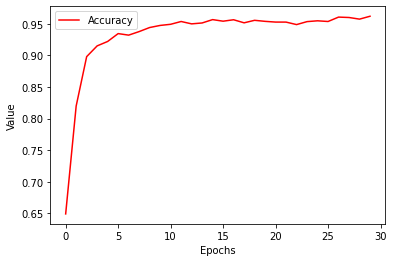

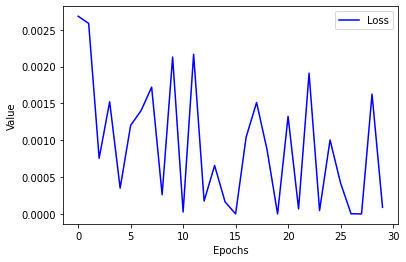

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('`', 'RD_PUNC'),
 ('મેરી', 'N_NNP'),
 ('માતા', 'N_NNP'),
 ('કે', 'N_NNP'),
 ('સર', 'N_NNP'),
 ('પે', 'N_NNP'),
 ('તાજ', 'N_NNP'),
 ('રહે', 'N_NNP'),
 ('`', 'RD_PUNC'),
 ('એ', 'DM_DMD'),
 ('રેકર્ડોએ', 'N_NN'),
 ('લોકપ્રિયતાના', 'N_NN'),
 ('તમામ', 'JJ'),
 ('આંક', 'N_NN'),
 ('તોડી', 'V_VM'),
 ('નાખ્યા', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('`', 'RD_PUNC'), ('મેરી', 'N_NNP'), ('માતા', 'N_NNP'), ('કે', 'RP_RPD'), ('સર', 'V_VAUX_VNP'), ('પે', 'N_NNP'), ('તાજ', 'N_NNP'), ('રહે', 'N_NNP'), ('`', 'RD_PUNC'), ('એ', 'DM_DMD'), ('રેકર્ડોએ', 'N_NN'), ('લોકપ્રિયતાના', 'V_VAUX_VNP'), ('તમામ', 'JJ'), ('આંક', 'N_NN'), ('તોડી', 'N_NN'), ('નાખ્યા', 'N_NN'), ('.', 'RD_PUNC')]
[('`', 'RD_PUNC'), ('સંગીત', 'N_NNP'), ('મકરંદમાં', 'N_NN'), ('`', 'RD_PUNC'), ('૧૯', 'N_NST'), ('પ્રકારની', 'N_NN'), ('વીણા', 'QT_QTC'), ('અને', 'CC_CCD'), ('૧૦૧', 'JJ'), ('પ્રકારના', 'N_NN'), ('તાલ', 'N_NN'), ('વર્ણવ્યા', 'N_NN'), ('છે', 'V_VAUX'), (',', 'RD_PUNC'), ('જે', 'PR_PRL'), ('આજે', 'N_NST'), ('પણ', 'RP_RPD'), ('ઉપયોગી', 'JJ'), ('સાબિત', 'V_VAUX_VNP'), ('થાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('ભરતમુનિ', 'N_NNP'), ('રચિત', 'JJ'), ('`', 'RD_PUNC'), ('નાટ્યશાસ્ત્ર', 'N_NNP'), ('`', 'RD_PUNC'), ('અને', 'CC_CCD'), ('નંદીકેશ્વર', 'N_NN'), ('રચિત', 'JJ'), ('`', 'RD_PUNC'), ('અભિનવ', 'PR_PRP'), ('દર્પણએ', 'N_NN'), ('`', 'RD_PUNC'), ('બે', 'QT_QTC'

In [ ]:
dict_true['art'] = y_true
dict_pred['art'] = y_pred

## Economy

In [ ]:
path = '/content/guj_economy_sample2.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3383
Unique tags: 29
Unique characters: 105


In [ ]:
word_to_idx.keys()

dict_keys(['દેશના', 'વિકાસમાં', 'પાયાની', 'સવલતો', 'ધરાવતા', 'માળખાને', 'મુખ્ય', 'બે', 'ભાગમાં', 'વહેંચવામાં', 'આવે', 'છે', '.', 'આર્થિક', 'આંતરમાળખું', 'અને', 'સામાજિક', 'આવી', 'સેવાઓનું', 'જેમ', 'ઉત્પાદન', 'વધતું', 'જાય', 'તેમ', 'અમુક', 'હદ', 'સુધી', 'એ', 'સેવાની', 'એકમ', 'દીઠ', 'ખર્ચ', 'ઘટતું', 'જેમકે', ',', 'વીજળીના', 'ઉત્પાદનમાં', 'વધારો', 'થાય', 'તો', 'થતું', 'ઉત્પાદનખર્ચ', 'ઘટે', 'સેવાઓનો', 'લાભ', 'તેમના', 'પ્રત્યક્ષ', 'ગ્રાહકો', 'પૂરતો', 'મર્યાદિત', 'રહેતો', 'નથી', 'લાભો', 'પરોક્ષ', 'રીતે', 'સમગ્ર', 'સમાજને', 'પ્રાપ્ત', 'વિકાસ', 'સાથે', 'સેવાઓ', 'ગાઢ', 'સંકળાયેલી', 'જણાય', 'વિશ્વ', 'બેંકે', 'આપેલા', 'અંદાજ', 'પ્રમાણે', 'સેવાઓના', 'જથ્થામાં', 'થતો', '૧', 'ટકાનો', 'રાષ્ટ્રીય', 'પેદાશના', 'ટકાના', 'વધારા', 'સંકળાયેલો', 'આને', 'કારણે', 'કેટલીક', 'સેવાઓમાં', 'રોકાયેલી', 'મૂડીનું', 'માથાદીઠ', 'મૂલ્ય', 'દેશની', 'આવક', 'સમખરીદશક્તિ', 'સિદ્ધાંત', 'અનુસાર', '૧૯૯૦માં', 'વિકિસત', 'દેશોની', '૨૦,૦૦૦', 'ડૉલર', 'જેટલી', 'હતી', 'ગરીબોનો', 'વસવાટ', 'શહેરના', 'ચોક્કસ', 'વિસ્તારોમાં', 'કેન્દ્રિત',

In [ ]:
char_to_idx.keys()

dict_keys(['દ', 'ે', 'શ', 'ન', 'ા', 'વ', 'િ', 'ક', 'સ', 'મ', 'ં', 'પ', 'ય', 'ી', 'લ', 'ત', 'ો', 'ધ', 'ર', 'ળ', 'ખ', 'ુ', '્', 'બ', 'ભ', 'ગ', 'હ', 'ચ', 'આ', 'છ', '.', 'થ', 'અ', 'જ', 'ઓ', 'ઉ', 'એ', 'ઠ', 'ઘ', 'ટ', ',', 'ષ', 'ૂ', 'ઢ', 'ણ', '૧', 'ડ', '૯', '૦', '૨', 'ૉ', 'ઈ', 'ફ', 'ઊ', 'ૌ', 'ૃ', '૪', '(', ')', '૫', '-', 'ૅ', '૬', '%', '૭', '૩', 'ઔ', 'ઝ', 'O', 'N', 'G', 'C', 'ઑ', 'ઍ', 'ૈ', '?', '/', '૮', 'P', 'ઞ', 'D', ':', 'i', 's', 'n', 'v', 'e', 't', 'm', 'ઇ', '`', 'ઃ', 'ઋ', 'p', 'r', 'a', 'o', 'R', 'c', 'h', 'I', 'd', 'S', 'u', ';'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.0008152800037350971	Accuracy: 0.844098428885142
Epoch 6 Completed,	Loss 0.0003550975158456519	Accuracy: 0.9434943993886312
Epoch 9 Completed,	Loss 0.00016409892054980446	Accuracy: 0.9529147346814474
Epoch 12 Completed,	Loss 0.0008239349020489802	Accuracy: 0.960063616434733
Epoch 15 Completed,	Loss 0.00018508875568083263	Accuracy: 0.9626356164614359
Epoch 18 Completed,	Loss 0.0003834847094030813	Accuracy: 0.9668562014897665
Epoch 21 Completed,	Loss 0.0002671337606443558	Accuracy: 0.9705573121706644
Epoch 24 Completed,	Loss 0.0020307132421235607	Accuracy: 0.9750694433848063
Epoch 27 Completed,	Loss 0.0001350164727105252	Accuracy: 0.9749078750610352
Epoch 30 Completed,	Loss 0.0006759353575110557	Accuracy: 0.9731668631235758


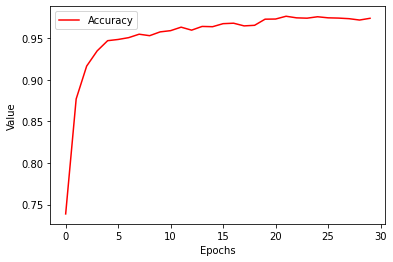

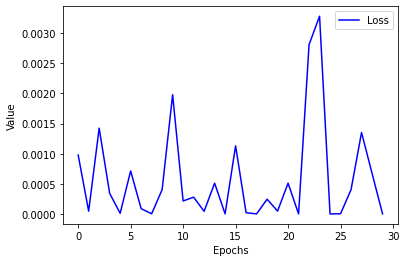

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('તેથી', 'PSP'),
 ('શહેરી', 'JJ'),
 ('ગરીબોને', 'N_NN'),
 ('કેટલીક', 'QT_QTF'),
 ('પાયાની', 'N_NN'),
 ('સેવાઓ', 'N_NN'),
 ('પૂરતા', 'JJ'),
 ('પ્રમાણમાં', 'N_NN'),
 ('પૂરી', 'JJ'),
 ('પાડવામાં', 'V_VAUX_VNP'),
 ('આવે', 'V_VAUX'),
 ('તે', 'DM_DMD'),
 ('ગરીબી', 'N_NN'),
 ('નિવારણના', 'N_NN'),
 ('દ્રષ્ટિબિંદુથી', 'N_NN'),
 ('જરૂરી', 'JJ'),
 ('થઈ', 'V_VM'),
 ('પડે', 'V_VAUX'),
 ('છે', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('તેથી', 'PSP'), ('શહેરી', 'N_NN'), ('ગરીબોને', 'N_NN'), ('કેટલીક', 'QT_QTF'), ('પાયાની', 'N_NN'), ('સેવાઓ', 'N_NN'), ('પૂરતા', 'N_NN'), ('પ્રમાણમાં', 'N_NN'), ('પૂરી', 'JJ'), ('પાડવામાં', 'JJ'), ('આવે', 'V_VAUX'), ('તે', 'DM_DMD'), ('ગરીબી', 'RB'), ('નિવારણના', 'V_VAUX_VNP'), ('દ્રષ્ટિબિંદુથી', 'N_NNP'), ('જરૂરી', 'JJ'), ('થઈ', 'V_VM'), ('પડે', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('કોઈ', 'DM_DMI'), ('પણ', 'RP_RPD'), ('માનવીય', 'V_VM'), ('પ્રવૃત્તિ', 'N_NN'), ('ઊર્જા', 'N_NN'), ('વિના', 'PSP'), ('શક્ય', 'JJ'), ('નથી', 'RP_NEG'), ('.', 'RD_PUNC')]
[('ત્યારબાદ', 'PSP'), ('બળદ', 'PSP'), (',', 'RD_PUNC'), ('ઘોડા', 'JJ'), (',', 'RD_PUNC'), ('ઊંટ', 'N_NN'), ('વગેરે', 'PSP'), ('જેવાં', 'PSP'), ('પ્રાણીઓ', 'N_NN'), ('ખેતીક્ષેત્રે', 'N_NN'), ('ઊર્જાના', 'N_NN'), ('સ્રોત', 'N_NN'), ('બન્યાં', 'N_NN'), ('.', 'RD_PUNC')]
[('ઉત્પાદનની', 'QT_QTO'), ('વિસરતી', 'RB'), ('ક્ષિતિજો', 'JJ'), ('જોતાં', 'QT_QTC'), ('આ', 'DM_DMD'), ('ખનિજ', 'N_NN'), ('તેલ', 'N_NN'), ('અને', 'CC_CCD'), ('ગૅસના', 

In [ ]:
dict_true['econo'] = y_true
dict_pred['econo'] = y_pred

## Philosophy

In [ ]:
path = '/content/guj_philosophy_sample4.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3914
Unique tags: 29
Unique characters: 78


In [ ]:
word_to_idx.keys()

dict_keys(['ભારતીય', 'તત્ત્વવિચારની', 'ગંગોત્રી', 'વેદ', 'છે', '.', 'મુખ્ય', 'અને', 'મહત્ત્વની', 'શાખાઓ', '-', 'આધારિત', 'એ', 'વેદને', 'પ્રમાણભૂત', 'માનીને', 'ચાલે', 'વેદના', 'અર્થઘટન', 'ને', 'વિસ્તરણ', 'રૂપે', 'વિકસે', 'આસ્તિક', 'દર્શનો', 'કહેવાય', 'એટલે', 'ઈશ્વરમાં', 'માનનાર', 'એવો', 'અર્થ', 'અહીં', 'નથી', 'આ', 'બધા', 'જગતકર્તા', 'માનનારાં', 'ન', 'એનાથી', 'ફંટાઈને', 'પ્રવર્તનાર', 'તે', 'નાસ્તિક', 'જેમકે', 'ચાર્વાક', ',', 'બૌદ્ધ', 'જૈન', 'વર્ગીકરણ', 'તત્ત્વવિચારના', 'કેન્દ્રમાં', 'તેનું', 'જ', 'સમર્થન', 'કરે', 'ભારતનું', 'પ્રાચીનતમ', 'સાહિત્ય', 'વેદનો', 'જ્ઞાન', 'થાય', 'ભારતમાં', 'તત્ત્વદર્શન', 'ઉપરાંત', 'ભાષા', 'સંગીત', 'ગણિત', 'ખગોળવિદ્યા', 'આદિ', 'અનેક', 'ક્ષેત્રોમાં', 'જે', 'કંઈ', 'વિચારણાઓ', 'થઈ', 'તેનાં', 'બીજ', 'વેદમાં', 'જોવામાં', 'આવે', 'રીતે', 'એનું', '`', 'નામ', 'સાર્થક', 'ઠરે', 'કોઈ', 'વ્યક્તિ', 'કે', 'પુરુષવિશેષનું', 'સર્જન', 'તેથી', 'એને', 'અનાદિ', 'અપૌરુષેય', 'ગણવામાં', 'ઈશ્વરપ્રણીત', 'હોવાનું', 'પણ', 'પરમાત્મા', 'પાસેથી', 'ઋષિઓએ', 'સાંભળેલા', 'મંત્રો', 'દિવ્યતાની', 'આર

In [ ]:
char_to_idx.keys()

dict_keys(['ભ', 'ા', 'ર', 'ત', 'ી', 'ય', '્', 'વ', 'િ', 'ચ', 'ન', 'ગ', 'ં', 'ો', 'ે', 'દ', 'છ', '.', 'મ', 'ુ', 'ખ', 'અ', 'હ', 'શ', 'ઓ', '-', 'આ', 'ધ', 'એ', 'પ', 'ણ', 'ૂ', 'લ', 'થ', 'ઘ', 'ટ', 'સ', 'ક', 'ઈ', 'બ', 'જ', 'ફ', ',', 'ૌ', 'ૈ', 'ઞ', 'ઉ', 'ષ', 'ળ', '`', 'ઠ', 'ઋ', '(', ')', ':', 'ઐ', 'ૃ', 'ડ', ';', 'ઇ', '૬', '૦', '૨', '૫', '૪', '૮', '૯', '૧', '૩', 'ઊ', 'ઢ', 'ઝ', '?', 'ૉ', '!', '૭', 'ઃ', 'ઔ'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.0020661301678046584	Accuracy: 0.8172899087270101
Epoch 6 Completed,	Loss 0.00022063539230051296	Accuracy: 0.9399202267328898
Epoch 9 Completed,	Loss 0.00030304671175448067	Accuracy: 0.9491379658381144
Epoch 12 Completed,	Loss 0.00035920679511036724	Accuracy: 0.9621394077936808
Epoch 15 Completed,	Loss 0.000691600376740098	Accuracy: 0.9636140465736389
Epoch 18 Completed,	Loss 0.0011164744549508516	Accuracy: 0.9708471099535624
Epoch 21 Completed,	Loss 0.0009994014787177246	Accuracy: 0.9712591767311096
Epoch 24 Completed,	Loss 0.0005888978489944444	Accuracy: 0.9731045365333557
Epoch 27 Completed,	Loss 0.0006615734915082309	Accuracy: 0.9756918350855509
Epoch 30 Completed,	Loss 6.222000935603618e-05	Accuracy: 0.9769904613494873


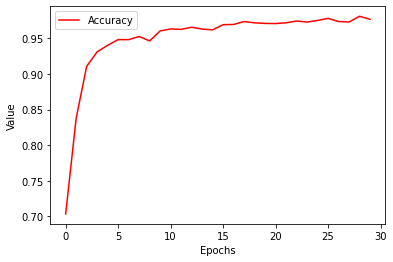

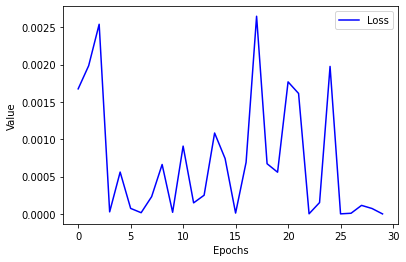

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('એ', 'DM_DMD'),
 ('વેદને', 'N_NNP'),
 ('પ્રમાણભૂત', 'JJ'),
 ('માનીને', 'V_VAUX_VNP'),
 ('ચાલે', 'V_VM'),
 ('છે', 'V_VAUX'),
 ('અને', 'CC_CCD'),
 ('વેદના', 'N_NNP'),
 ('અર્થઘટન', 'N_NN'),
 ('ને', 'CC_CCD'),
 ('વિસ્તરણ', 'N_NN'),
 ('રૂપે', 'N_NN'),
 ('વિકસે', 'V_VM'),
 ('છે', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('એ', 'DM_DMD'), ('વેદને', 'N_NNP'), ('પ્રમાણભૂત', 'JJ'), ('માનીને', 'N_NN'), ('ચાલે', 'V_VM'), ('છે', 'V_VAUX'), ('અને', 'CC_CCD'), ('વેદના', 'N_NNP'), ('અર્થઘટન', 'N_NN'), ('ને', 'CC_CCD'), ('વિસ્તરણ', 'N_NN'), ('રૂપે', 'N_NN'), ('વિકસે', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આરણ્યક', 'N_NNP'), (':', 'RD_PUNC'), ('એ', 'DM_DMD'), ('બ્રાહ્મણ', 'N_NNP'), ('અને', 'CC_CCD'), ('ઉપનિષદ', 'N_NNP'), ('કડી', 'JJ'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એ', 'DM_DMD'), ('વેદાંગ', 'N_NNP'), ('તરીકે', 'PSP'), ('મનાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('સંસ્કૃતકાળના', 'N_NN'), ('પ્રતિષ્ઠિત', 'JJ'), ('ઋષિમુનિઓના', 'V_VAUX_VNP'), ('રચેલા', 'JJ'), ('ગ્રંથો', 'N_NN'), ('તે', 'DM_DMD'), ('સર્વ', 'JJ'), ('`', 'RD_PUNC'), ('સ્મૃતિ', 'N_NNP'), ('`', 'RD_PUNC'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('દર્શનોએ', 'N_NN'), ('સ્વીકારેલાં', 'N_NN'), ('૨૫', 'JJ'), ('તત્ત્વો', 'JJ'), ('આ', 'DM_DMD'), ('મુજબ', 'PSP'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('એ', 'DM_DMD'), ('અવિકારી', 'PR_PRP')

In [ ]:
dict_true['philo'] = y_true
dict_pred['philo'] = y_pred

## Relegion

In [ ]:
path = '/content/guj_religion_sample5.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 4242
Unique tags: 29
Unique characters: 81


In [ ]:
word_to_idx.keys()

dict_keys(['શિવજીની', 'બે', 'અવસ્થાઓ', 'માનવામાં', 'આવી', 'છે', '.', 'તેમાંથી', 'એક', 'સમાધિ', 'અને', 'બીજી', 'તાંડવ', 'અથવા', 'લાસ્ય', 'નૃત્ય', 'અવસ્થા', 'અર્થાત્', 'નિર્ગુણ', 'નૃત્યાવસ્થા', 'એટલે', 'સગુણ', 'એકાદી', 'નિશ્ચિત', 'ઘટના', 'વિષય', 'અભિવ્યક્ત', 'કરવા', 'માટે', 'જે', 'અંગચાલન', 'કરવામાં', 'આવે', 'તેને', 'નટન', 'નાટ્ય', 'એવી', 'સંજ્ઞા', 'આ', 'કરે', 'તે', 'નટ', 'શિવજી', 'એ', 'આદ્યનટ', 'શ્રદ્ધા', 'હોવાથી', 'તેમને', '`', 'નટરાજનું', 'બિરુદ', 'મળ્યું', 'બ્રહ્માંડ', 'નટરાજની', 'નૃત્યશાળા', 'તેઓ', 'રીતે', 'નર્તક', ',', 'તેના', 'સાક્ષી', 'પણ', 'નટરાજ', 'કલ્પના', 'પાછળની', 'ભૂમિકા', 'સૃષ્ટિ', 'સ્થિતિ', 'સંહાર', 'તિરોભાવ', '(', 'માયાનું', 'આવરણ', ')', 'અનુગ્રહ', 'પાંચ', 'ઈશ્વરી', 'ક્રિયાઓનું', 'દ્યોતક', 'શિવજીએ', 'પોતે', 'પહેલા', 'કરેલું', 'ઉદ્વત', 'નૃત્યનું', 'સ્મરણ', 'કરીને', 'પોતાના', 'ગણોમાંના', 'અગ્રણી', 'રહેલા', 'તંડૂ', 'દ્વારા', 'ભરતમુનિને', 'બતાવ્યું', 'લાસ્ય:', 'સ્ત્રી', 'તેમાં', 'હાથ', 'મુક્ત', 'હોય', 'તંડુએ', 'કરી', 'એવું', 'સમજીને', 'ભરત', 'ઈત્યાદિ', 'મુનિઓએ', 'માનવોને', '

In [ ]:
char_to_idx.keys()

dict_keys(['શ', 'િ', 'વ', 'જ', 'ી', 'ન', 'બ', 'ે', 'અ', 'સ', '્', 'થ', 'ા', 'ઓ', 'મ', 'ં', 'આ', 'છ', '.', 'ત', 'એ', 'ક', 'ધ', 'ડ', 'લ', 'ય', 'ૃ', 'ર', 'ગ', 'ુ', 'ણ', 'ટ', 'દ', 'ચ', 'ઘ', 'ષ', 'ભ', 'ઞ', 'હ', 'ો', '`', 'ળ', ',', 'પ', 'ૂ', '(', ')', 'ઈ', 'ઉ', ':', 'ખ', 'ૈ', 'ૌ', 'ફ', 'ઢ', '-', '૧', '૪', 'ઝ', 'ઠ', '૩', '૫', '?', '૨', '૦', '+', 'ઔ', 'ઊ', 'ઋ', 'ઃ', '!', '૬', '૯', '૮', 'ઐ', '૭', 'ૉ', '/', ';', 'ઇ', "'"])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.004130407469347119	Accuracy: 0.746454656124115
Epoch 6 Completed,	Loss 0.0011478881545675297	Accuracy: 0.9157126545906067
Epoch 9 Completed,	Loss 0.0008779661438893527	Accuracy: 0.9242690006891886
Epoch 12 Completed,	Loss 0.000835399565479141	Accuracy: 0.9389387369155884
Epoch 15 Completed,	Loss 1.0581086968090385e-06	Accuracy: 0.94465039173762
Epoch 18 Completed,	Loss 0.0001911460852686749	Accuracy: 0.9508622487386068
Epoch 21 Completed,	Loss 1.9987725560592176e-06	Accuracy: 0.9553879102071127
Epoch 24 Completed,	Loss 3.6868708111666613e-05	Accuracy: 0.9568335811297098
Epoch 27 Completed,	Loss 0.0019687438558691948	Accuracy: 0.960631251335144
Epoch 30 Completed,	Loss 1.1037521474577261e-07	Accuracy: 0.9605134328206381


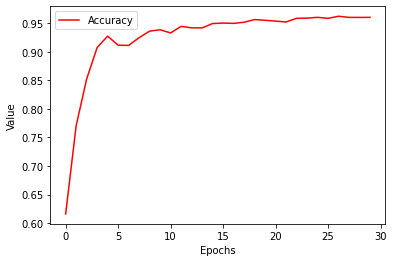

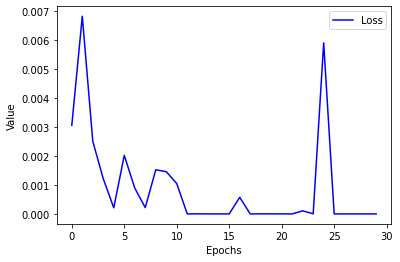

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('તેમાંથી', 'DM_DMD'),
 ('એક', 'QT_QTC'),
 ('સમાધિ', 'N_NN'),
 ('અને', 'CC_CCD'),
 ('બીજી', 'JJ'),
 ('તાંડવ', 'N_NN'),
 ('અથવા', 'CC_CCD'),
 ('લાસ્ય', 'N_NN'),
 ('નૃત્ય', 'N_NN'),
 ('અવસ્થા', 'N_NN'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('તેમાંથી', 'RP_RPD'), ('એક', 'QT_QTC'), ('સમાધિ', 'N_NN'), ('અને', 'CC_CCD'), ('બીજી', 'JJ'), ('તાંડવ', 'N_NN'), ('અથવા', 'CC_CCD'), ('લાસ્ય', 'N_NN'), ('નૃત્ય', 'N_NN'), ('અવસ્થા', 'N_NN'), ('.', 'RD_PUNC')]
[('કલ્યાણને', 'PR_PRQ'), ('પામવાનું', 'N_NN'), ('ઉત્તમ', 'JJ'), ('શિખર', 'N_NN'), ('શિવ', 'N_NNP'), ('કહેવાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('સમસ્ત', 'JJ'), ('પ્રાણીઓના', 'N_NN'), ('વિશ્રામ', 'N_NN'), ('સ્થાન', 'N_NN'), ('તરીકે', 'DM_DMD'), ('શિવજીને', 'N_NNP'), ('ઓળખવામાં', 'V_VAUX_VNP'), ('આવી', 'V_VM'), ('રહ્યા', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('જેમનું', 'PR_PRL'), ('શરીર', 'N_NN'), ('વૃદ્ધાવસ્થા', 'V_VAUX_VNP'), ('દર્શાવે', 'V_VAUX_VNP'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('બધું', 'QT_QTF'), ('જ', 'RP_RPD'), ('દેવાધિદેવ', 'N_NN'), ('શ્રી', 'N_NN'), ('વિશ્વકર્મા', 'N_NNP'), ('પ્રભુની', 'N_NNP'), ('જ', 'RP_RPD'), ('દેન', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('તેથી', 'PSP'), ('વિશ્વકર્મા', 'N_NNP'), ('વંશજો', 'N_NN'),

In [ ]:
dict_true['relegion'] = y_true
dict_pred['relegion'] = y_pred

## entern

In [ ]:
path = '/content/guj_entertainment_sample3.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3715
Unique tags: 28
Unique characters: 64


In [ ]:
word_to_idx.keys()

dict_keys(['શુકલની', 'ફેવર', 'કરી', 'એ', 'ભૂલ', 'થઈ', '.', 'ખરેખર', 'તો', 'સારું', 'કામ', 'કરે', 'છે', 'ને', 'વળી', 'ઉપયોગી', 'માણસ', 'પણ', 'ખરો', '-', 'એવું', 'સાહેબ', 'આગળ', 'બોલવું', 'જ', 'નહોતું', 'જોઈતું', 'બોલાઈ', 'ગયું', 'એને', 'પ્રમોશન', 'મળ્યું', 'એક', 'દલિતના', 'હાથે', 'સવર્ણનો', 'ઉદ્ધાર', 'થયો', '!', 'જોકે', 'હું', 'ન', 'બોલત', 'ય', 'એનું', 'થવાનું', 'હતું', 'પછી', 'બૂરા', 'શું', 'બનવું', '?', 'કામનો', 'ડ્રાફ્ટિંગ', 'તમે', 'જેવું', 'વિચારતા', 'હો', 'લખી', 'આપે', 'અને', 'સહેજ', 'છેકછાક', 'વગર', 'ગમે', 'એમ', 'મૂળે', 'બામણનો', 'દીકરો', ',', 'ઘરના', 'સંસ્કાર', 'એટલે', 'જાણે', 'સરસ્વતી', 'જીભે', 'આમ', 'એના', 'વખાણ', 'કરવા', 'જોઈએ', '`', 'રૂલબુકની', 'વિરુદ્ધની', 'વાત', 'ચાવડાએ', 'બધાની', 'વચ્ચે', 'કહ્યું', 'કે', 'આ', 'સોલંકી', 'પેલી', 'ચોટલીના', 'જ્યાં', 'હોય', 'ત્યાં', 'કર્યા', 'આપણી', 'રૂલબુકનો', 'છડેચોક', 'ભંગ', 'ના', 'ચાલે', 'મહેતાએ', 'ટાપસી', 'પુરાવી', 'હતી', 'હા', 'પરમ', 'દિવસે', 'એની', 'ઑફિસે', 'ગયો', 'હતો', 'મેં', 'કાને', 'સાંભળ્યું', 'સગી', 'આંખે', 'જોયું', 'બધા', 'કાગડાન

In [ ]:
char_to_idx.keys()

dict_keys(['શ', 'ુ', 'ક', 'લ', 'ન', 'ી', 'ફ', 'ે', 'વ', 'ર', 'એ', 'ભ', 'ૂ', 'થ', 'ઈ', '.', 'ખ', 'ત', 'ો', 'સ', 'ા', 'ં', 'મ', 'છ', 'ળ', 'ઉ', 'પ', 'ય', 'ગ', 'ણ', '-', 'હ', 'બ', 'આ', 'જ', '્', 'દ', 'િ', 'ધ', '!', '?', 'ડ', 'ટ', 'ચ', 'અ', ',', 'ઘ', '`', 'ઑ', 'ઊ', 'ઝ', ':', 'ઢ', 'ઓ', 'ઠ', 'ૌ', 'ૃ', 'ૈ', 'ષ', 'ૉ', 'ૅ', 'ઞ', ';', 'ઔ'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.0014107311920573313	Accuracy: 0.7538947463035583
Epoch 6 Completed,	Loss 0.001656858289303879	Accuracy: 0.9027381340662638
Epoch 9 Completed,	Loss 0.0011702888223226182	Accuracy: 0.9192277391751608
Epoch 12 Completed,	Loss 0.0015256275170637916	Accuracy: 0.9345957438151041
Epoch 15 Completed,	Loss 0.00044513135799206793	Accuracy: 0.9372238715489706
Epoch 18 Completed,	Loss 0.001700492265323798	Accuracy: 0.9423737128575643
Epoch 21 Completed,	Loss 0.0005937166680117419	Accuracy: 0.9461705883344015
Epoch 24 Completed,	Loss 0.0014726697700098157	Accuracy: 0.9473949273427328
Epoch 27 Completed,	Loss 0.001263320087067162	Accuracy: 0.9504273931185404
Epoch 30 Completed,	Loss 0.003405370827143391	Accuracy: 0.9553846716880798


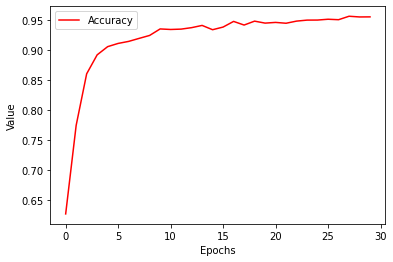

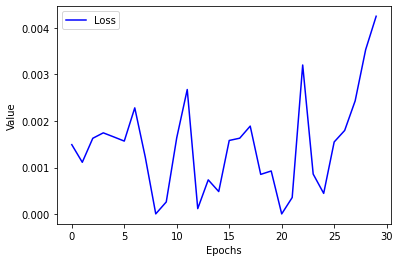

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('એને', 'PR_PRP'), ('પ્રમોશન', 'N_NN'), ('મળ્યું', 'V_VM'), ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('એને', 'PR_PRP'), ('પ્રમોશન', 'N_NN'), ('મળ્યું', 'V_VM'), ('.', 'RD_PUNC')]
[('જોકે', 'CC_CCS'), ('હું', 'PR_PRP'), ('ન', 'RP_NEG'), ('બોલત', 'V_VAUX'), ('તો', 'RP_RPD'), ('ય', 'RP_RPD'), ('એનું', 'PR_PRP'), ('પ્રમોશન', 'V_VM'), ('તો', 'RP_RPD'), ('થવાનું', 'V_VM'), ('જ', 'RP_RPD'), ('હતું', 'V_VAUX'), ('.', 'RD_PUNC')]
[('પછી', 'PSP'), ('તો', 'RP_RPD'), ('બધા', 'QT_QTF'), ('કાગડાની', 'JJ'), ('જેમ', 'PSP'), ('કા', 'CC_CCD'), ('કા', 'N_NST'), ('કા', 'N_NST'), ('કરતાં', 'V_VAUX_VNP'), ('જાત', 'V_VAUX'), ('ઉપર', 'N_NST'), ('ઊતરી', 'V_VM'), ('આવ્યા', 'V_VM'), ('.', 'RD_PUNC')]
[('અમારાવાળાની', 'N_NN'), ('ભૂલો', 'N_NN'), ('સામે', 'PSP'), ('આંખમીંચામણા', 'V_VM'), ('તો', 'RP_RPD'), ('કદીયે', 'N_NN'), ('નથી', 'RP_NEG'), ('કર્યાં', 'V_VM'), ('.', 'RD_PUNC')]
[('હવે', 'N_NST'), ('આ', 'DM_DMD'), ('આંકડા', 'N_NN'), ('જ', 'RP_RPD'), ('ઉપજાવી', 'V_VM'), ('કાઢેલા', 'V_VM'), ('હોય', 'V_VAUX'), ('તો', 'CC_CCD'), ('હું', 'PR_PRP'), ('કે', 'CC_CCS'), ('એ', 'DM_DMD'), ('શું', 'PR_PRQ'), ('કરીએ', 'V_VM'

In [ ]:
dict_true['entern'] = y_true
dict_pred['entern'] = y_pred

## scie

In [ ]:
path = '/content/guj_science and technology_sample6.txt'

def process_file(path):
  f = open(path,'r')
  tagged_sentence = []
  for line in f:
    line = line.split()[1:]
    temp = []
    for i in line:
      i = i.split('\\')
      temp.append((i[0],i[1]))
    tagged_sentence.append(temp)

  return tagged_sentence


tagged_sentence = process_file(path)
print(len(tagged_sentence))

1000


In [ ]:

def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 5544
Unique tags: 31
Unique characters: 131


In [ ]:
word_to_idx.keys()

dict_keys(['વસ્તી', 'વધારાથી', 'સર્જાતું', 'દબાણ', 'મુખ્ય', 'બે', 'ચાવીરૂપ', 'પરિબળમાં', 'પ્રતિબિંબિત', 'થાય', 'છે', '.', 'વધારાનો', 'દર', 'અને', 'વિશ્વની', 'કુલ', 'વસ્તીમાં', 'વર્ષે', 'થતો', 'વધારો', 'છેલ્લા', 'કેટલાક', 'દાયકાઓથી', 'ઘટી', 'રહ્યો', ',', 'જ્યારે', 'ભવિષ્યમાં', 'પણ', 'રહેશે', '૧૯૯૦ના', 'દાયકામાં', 'અત્યાર', 'સુધીમાં', 'સર્વાધિક', 'એવી', 'લગભગ', '૧૦', 'કરોડ', 'માણસોની', 'વાર્ષિક', 'વૃદ્ધિ', 'થઈ', 'રહી', 'માનવ', 'સંખ્યામાં', 'આવો', 'અભૂતપૂર્વ', 'ઝડપી', 'તેની', 'વહેંચણીની', 'તરાહ', 'વિકાસની', 'પ્રક્રિયા', 'આડે', 'ગંભીર', 'અવરોધ', 'સર્જે', 'ખાસ', 'કરીને', 'વિકાસગામી', 'દેશોના', 'આર્થિક', 'આધાર', 'સમા', 'કુદરતી', 'સાધનોના', 'પાયા', 'ઉપર', 'અસહ્ય', 'બોજ', 'વધારે', 'વધુમાં', 'વિકાસ', 'પામતા', 'સમાજને', 'સંતોષવા', 'આયોજન', 'સાધવાની', 'સરકારની', 'ક્ષમતા', 'તે', 'પોતાનો', 'પ્રચંડ', 'પ્રભાવ', 'જમાવે', 'વળી', 'એકાએક', 'ફાટી', 'નીકળતી', 'વધુ', 'વસ્તીને', 'મૂળભૂત', 'સેવાઓ', 'સગવડોના', 'રૂપમાં', 'અર્ધસામાજિક', 'માળખું', 'પૂરું', 'પાડવાનો', 'પૂરતો', 'સમય', 'સુદ્ધાં', 'મળતો', 'નથી', 'તમા

In [ ]:
char_to_idx.keys()

dict_keys(['વ', 'સ', '્', 'ત', 'ી', 'ધ', 'ા', 'ર', 'થ', 'જ', 'ુ', 'ં', 'દ', 'બ', 'ણ', 'મ', 'ખ', 'ય', 'ે', 'ચ', 'ૂ', 'પ', 'િ', 'ળ', 'છ', '.', 'ન', 'ો', 'અ', 'શ', 'ક', 'લ', 'ષ', 'ટ', 'ઓ', 'ઘ', 'હ', ',', 'ભ', '૧', '૯', '૦', 'એ', 'ગ', 'ડ', 'ૃ', 'ઈ', 'આ', 'ઝ', 'ઉ', 'ફ', 'ઊ', 'ઔ', 'ઠ', 'ૈ', '૫', '૩', '`', '?', '-', 'ૌ', '૨', '૬', '૮', ';', '૪', '૭', 'ઢ', 'ઞ', '(', 'G', 'F', 'T', 'o', 'u', 'r', 'n', 'e', 'c', 'h', ')', 'ઃ', 'p', 't', 'i', 'a', 'm', 'ઇ', 'I', 'd', 'P', 's', 'f', 'R', 'S', 'g', 'y', 'N', 'A', 'l', 'M', 'D', 'C', 'E', '&', 'v', 'b', 'O', '/', 'U', 'ઋ', ':', 'B', '1', 'ૉ', 'x', '2', '%', 'q', 'k', 'W', 'w', '=', 'J', 'Q', 'V', 'H', 'ૅ', 'ઑ', '!', 'ઍ'])

In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 30

class DualLSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
    super(DualLSTMTagger, self).__init__()
    self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
    
    self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
    self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
    
    self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
    self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
      
  def forward(self, sentence, words):
    embeds = self.word_embedding(sentence)
    char_hidden_final = []
    for word in words:
        char_embeds = self.char_embedding(word)
        _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
        word_char_hidden_state = char_hidden.view(-1)
        char_hidden_final.append(word_char_hidden_state)
    char_hidden_final = torch.stack(tuple(char_hidden_final))
    
    combined = torch.cat((embeds, char_hidden_final), 1)

    lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    model.cuda()

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 10.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:]))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 3 Completed,	Loss 0.002559607926135262	Accuracy: 0.7974267601966858
Epoch 6 Completed,	Loss 0.0024117883682871857	Accuracy: 0.9257955153783163
Epoch 9 Completed,	Loss 0.0013713323386355114	Accuracy: 0.9310397505760193
Epoch 12 Completed,	Loss 0.0014962677899651073	Accuracy: 0.9337471524874369
Epoch 15 Completed,	Loss 0.001444224927884837	Accuracy: 0.9420058131217957
Epoch 18 Completed,	Loss 0.001469766933913282	Accuracy: 0.9462142189343771
Epoch 21 Completed,	Loss 0.004388765955916085	Accuracy: 0.9433196981747946
Epoch 24 Completed,	Loss 0.0021069346394142485	Accuracy: 0.9465948939323425
Epoch 27 Completed,	Loss 2.2448539311881177e-05	Accuracy: 0.9448942144711813
Epoch 30 Completed,	Loss 1.008835491404329e-06	Accuracy: 0.9452975193659464


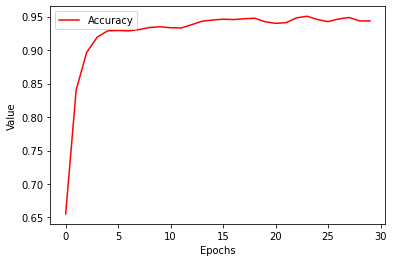

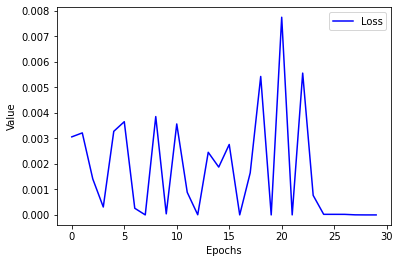

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
test[0]

[('વસ્તી', 'N_NN'),
 ('વધારાથી', 'N_NN'),
 ('સર્જાતું', 'V_VAUX_VNP'),
 ('દબાણ', 'N_NN'),
 ('મુખ્ય', 'JJ'),
 ('બે', 'QT_QTC'),
 ('ચાવીરૂપ', 'N_NN'),
 ('પરિબળમાં', 'N_NN'),
 ('પ્રતિબિંબિત', 'JJ'),
 ('થાય', 'V_VM'),
 ('છે', 'V_VAUX'),
 ('.', 'RD_PUNC')]

In [ ]:
y_true = []
y_pred = []
for sentence in test:
  seq = ""
  for s in range(len(sentence)):
    if(s==(len(sentence)-1)):
      seq+= sentence[s][0]
    else:
      seq += sentence[s][0] + " "
    y_true.append(sentence[s][1])
  
  seq = seq.split()
  with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
                y_pred.append(key)
    print(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[('વસ્તી', 'N_NN'), ('વધારાથી', 'V_VAUX_VNP'), ('સર્જાતું', 'JJ'), ('દબાણ', 'V_VM'), ('મુખ્ય', 'JJ'), ('બે', 'QT_QTC'), ('ચાવીરૂપ', 'JJ'), ('પરિબળમાં', 'N_NN'), ('પ્રતિબિંબિત', 'JJ'), ('થાય', 'V_VM'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('આ', 'DM_DMD'), ('પ્રાથમિક', 'JJ'), ('રીતે', 'N_NNP'), ('અયોગ્ય', 'N_NN'), ('ટેકનોલોજી', 'N_NN'), ('અને', 'CC_CCD'), ('વધુ', 'QT_QTF'), ('પડતા', 'CC_CCD'), ('ગ્રાહકવાદનો', 'N_NN'), ('પ્રશ્ન', 'N_NN'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('પણ', 'RP_RPD'), ('તેમાં', 'DM_DMD'), ('પણ', 'RP_RPD'), ('વસ્તીની', 'PR_PRF'), ('સમસ્યાનો', 'N_NN'), ('પડઘો', 'N_NNP'), ('પડી', 'N_NN'), ('રહ્યો', 'V_VAUX'), ('છે', 'V_VAUX'), ('.', 'RD_PUNC')]
[('વળી', 'PSP'), (',', 'RD_PUNC'), ('નીતિવિષયક', 'JJ'), ('પહેલ', 'QT_QTC'), ('અને', 'CC_CCD'), ('કાર્યક્રમોના', 'JJ'), ('પગલાં', 'N_NN'), ('વડે', 'PSP'), ('પણ', 'RP_RPD'), ('તે', 'DM_DMD'), ('પ્રત્યે', 'PSP'), ('પૂરતું', 'JJ'), ('ધ્યાન', 'N_NN'), ('અપાયું', 'JJ'), ('નથી', 'RP_NEG'), ('.', 'RD_PUNC')]
[('આવા', 'JJ'), ('અન્ય', '

In [ ]:
dict_true['sci'] = y_true
dict_pred['sci'] = y_pred

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

for i in k:
  y_true = dict_true[i]
  y_pred = dict_pred[i]
  print(y_true)
  print(y_pred)
  Acc_plot.append(accuracy_score(y_true, y_pred))
  recall.append(recall_score(y_true,y_pred,average='macro'))
  precision_plot.append(precision_score(y_true,y_pred,average='macro'))
  f1score_plot.append(f1_score(y_true, y_pred,average='macro'))

print(Acc_plot)
print(recall)
print(precision_plot)
print(f1score_plot)